In [17]:
import tensorflow as tf
import numpy as np
import os
import time
import sys
import pickle
from rnn_dynamic import *
import scipy
from scipy import spatial
import pandas as pd
import seaborn as sns
import pylab as plt
from sklearn.manifold import TSNE

In [2]:
checkpoint_path = 'checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000'
research_question_code = 'test'
remove_already_rated = True

In [3]:
max_interactions = 100
# tensorflow model
model_parameters = {}
model_parameters['opt'] = 'adam'
model_parameters['learning_rate'] = 0.001
model_parameters['n_hidden'] = 256
model_parameters['batch_size'] = 128
model_parameters['rnn_type'] = 'lstm2'
model_parameters['rnn_layers'] = 1
model_parameters['dropout'] = 0.0
model_parameters['l2_reg'] = 0.0
model_parameters['type_output'] = 'embeddings'
model_parameters['max_steps'] = 3000000
model_parameters['padding'] = 'right'
model_parameters['embedding_size'] = 0
model_parameters['embedding_activation'] = 'linear'
model_parameters['y_length'] = 1
model_parameters['W_emb_init'] = 'W_emb_64'
model_parameters['init_stdev'] = 0.1
type_input = 'embeddings'
input_embeddings_size = 64

In [4]:
with open("pickles/movielens/X_test_" + str(max_interactions) + "_embeddings_" + str(input_embeddings_size) + "_2009_filter20_rep2.pickle", 'rb') as handle:
    X_test = pickle.load(handle)
with open("pickles/movielens/Y_test_" + str(max_interactions) + "_embeddings_" + str(input_embeddings_size) + "_2009_filter20_rep2.pickle", 'rb') as handle:
    Y_test = pickle.load(handle)
with open("pickles/movielens/X_test_" + str(max_interactions) + "_2009_filter20_rep2.pickle", 'rb') as handle:
    X_test2 = pickle.load(handle)

In [5]:
model_parameters['n_input'] = X_test[0].shape[1]
if model_parameters['type_output'] == 'embeddings':
    model_parameters['n_output'] = input_embeddings_size
    with open("pickles/movielens/" + "W_emb_64" + ".pickle", 'rb') as handle:
        W_emb = pickle.load(handle)
        W_emb = W_emb.astype(np.float32)
else:
    model_parameters['n_output'] = Y_test[0].shape[1]
model_parameters['seq_length'] = X_test[0].shape[0]

In [6]:
print('Input dimension: ' + str(model_parameters['n_input']))
print('Output dimension: ' + str(model_parameters['n_output']))

Input dimension: 64
Output dimension: 64


In [7]:
# Create tensorflow model and train
print('Create model...')
model = RNN_dynamic(model_parameters)
model.create_model()

Create model...


C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [8]:
import gensim, logging
# Load word2vec
word2vec = gensim.models.Word2Vec.load("word2vec_64_window_10_iters_25_start_2009-01-01.bin")


movies_min_ratings = 20
min_seq_length = 5
max_seq_length = 100

start_date_train = '2009-01-01'
date_test = '2014-10-01'
# STEP 2: CREATE TRAINING SAMPLES USING THE EMBEDDINGS
print('Create training samples')
# Ratings .dat format: UserID::MovieID::Rating::Timestamp
user_ids = []
movie_ids = []
ratings = []
timestamps = []
dataset_file = "../data/Movielens/ml-20m/ratings.csv"
df = pd.read_csv(dataset_file)
df['userId'] = df['userId'].astype(np.int32)
df['movieId'] = df['movieId'].astype(np.int32)
df['rating'] = df['rating'].astype(np.float16)
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

df_date = df[df.date > start_date_train]


# Filter out movies with less than X ratings
filter_movies = df_date.movieId.value_counts()[(df_date.movieId.value_counts() > movies_min_ratings)].index.values
df_date = df_date[df_date.movieId.isin(filter_movies)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()
# Filter out users with less than X ratings
filter_users = df_date['userId'].value_counts()[(df_date['userId'].value_counts() >= min_seq_length)].index.values
df_date = df_date[df_date.userId.isin(filter_users)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()

# Build array mapping movie_id --> position in one-hot encoding
print('Build array mapping movie_id --> position in one-hot encoding')
movieIds = np.zeros(max(df_date['movieId'].unique()) + 1, np.uint16)
i = 0
for movieId in df_date['movieId'].unique():
    movieIds[movieId] = i
    i += 1

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Create training samples
Total number of ratings:4687202
Number of different users: 36395
Number of different movies: 10057
Total number of ratings:4685946
Number of different users: 35821
Number of different movies: 10057
Build array mapping movie_id --> position in one-hot encoding


In [9]:
# Create dictionary dict_movie[position one-hot] = id movilens data set
dict_movies = {}
for i in range(len(movieIds)):
    if movieIds[i] != 0:
        dict_movies[movieIds[i]] = i
dict_movies[0] = 1 # Manually entry, as many items in the array are 0, but this is the one which belongs to an item id

In [10]:
dataset_file = "../data/Movielens/ml-20m/movies.csv"
df_movies = pd.read_csv(dataset_file)
print(len(df_movies.movieId.unique()))
df_movies = df_movies[df_movies.movieId.isin(df_date.movieId.unique())]
print(len(df_movies.movieId.unique()))

# Preprocess year
years = []
for movie_title in df_movies.title:
    year = movie_title[movie_title.find("(")+1:movie_title.find(")")]
    if not year.isdigit():
        year = 0
    years.append(int(year))
df_movies['year'] = years

27278
10057


In [15]:
data_tsne = []
dict_movieId_pos = {}
i = 0
for word in word2vec.wv.vocab:
    vector = word2vec[word]
    data_tsne.append(vector)
    dict_movieId_pos[word] = i
    i += 1
data_tsne = np.array(data_tsne)

In [11]:
# Train T-SNE with all the data
from sklearn.manifold import TSNE

data_tsne = []
dict_movieId_pos = {}
i = 0
for word in word2vec.wv.vocab:
    vector = word2vec[word]
    data_tsne.append(vector)
    dict_movieId_pos[word] = i
    i += 1
    
data_tsne = np.array(data_tsne)
print(data_tsne.shape)
model_tsn_all = TSNE(n_components=2, random_state=17)
Y_tsn_all = model_tsn_all.fit_transform(data_tsne)

# Create data frame
df_tsne = pd.concat([pd.DataFrame(Y_tsn_all),
                pd.Series(list(word2vec.wv.vocab))],
               axis=1)

df_tsne.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_tsne.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
df_tsne['title'] = titles
df_tsne['genres'] = genres
df_tsne['years'] = years

(10057, 64)
DEBUG
<class 'str'>
random
Condition 1:
False
Condition 2:
False
END DEBUG


In [25]:
l_already_watched

array([ 386,   85, 1319, 1188, 1343, 1276,  690, 1260,  237,  320,  671,
        432,  758, 1321, 1341, 1346,  735,  748, 1248,  172, 1342,  953,
       1195,  574, 1231,  785, 1294, 1344, 1014,   70, 1242,  714,  536,
       1275,  557, 1312, 1194, 1282, 1281,  524,  757,  614, 1190, 1234,
       1314, 1081, 1304,  265,   87,   67, 1048,  255,  324, 1279,  784,
       1339,  780,  590,  142,  706, 1162, 1207,  443, 1338, 1300, 1197,
       1308, 1254, 1354, 1084, 1350, 1284, 1349, 1347,  760,  958,  956,
        529,  352, 1348, 1351, 1358, 1287, 1335, 1262, 1328,  733, 1247,
       1352, 1355, 1353, 1286, 1211, 1309, 1330, 1324,  761, 1256, 1332,
       1345], dtype=int64)

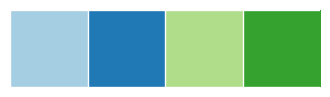

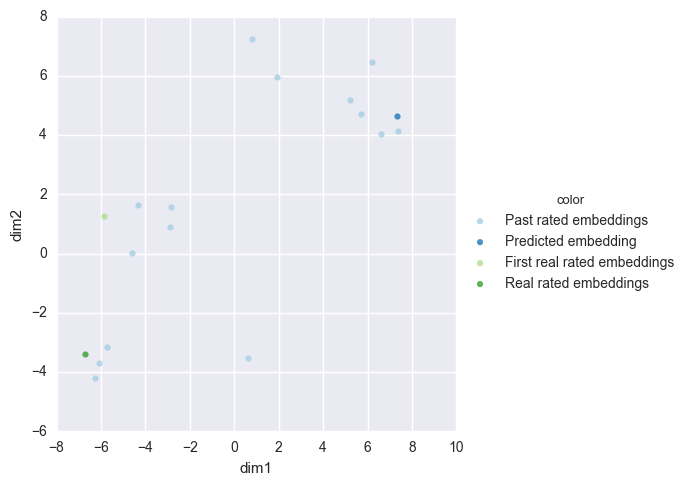

In [35]:
#palette
new_palette = sns.color_palette("Paired", 4)
sns.palplot(new_palette)
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, palette=new_palette)
plt.show()

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


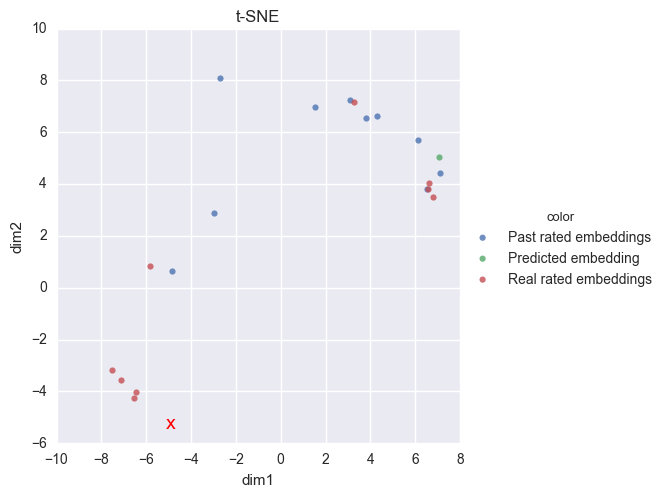

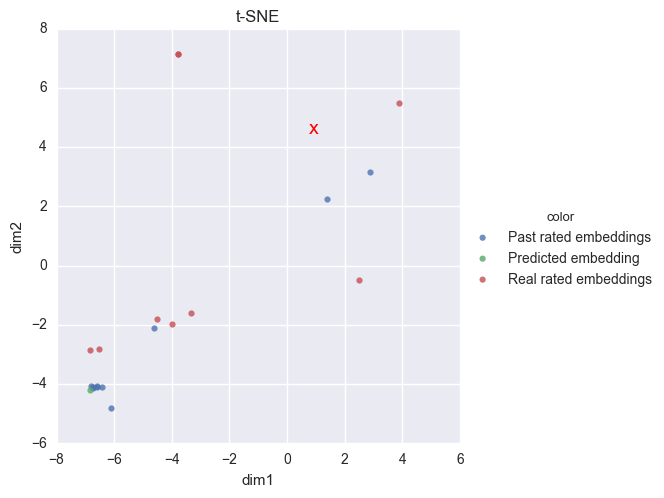

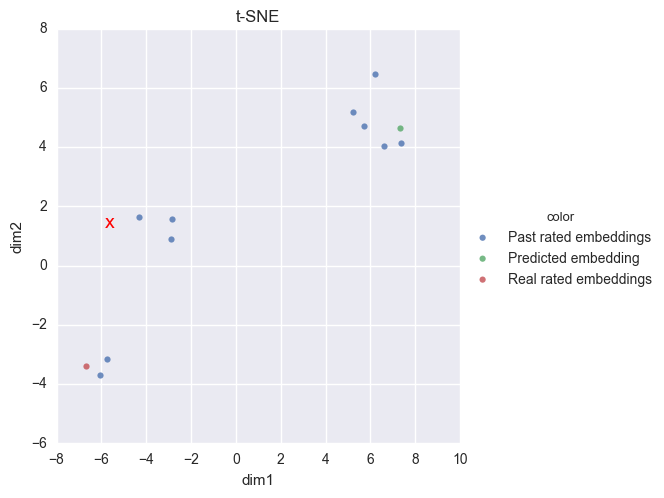

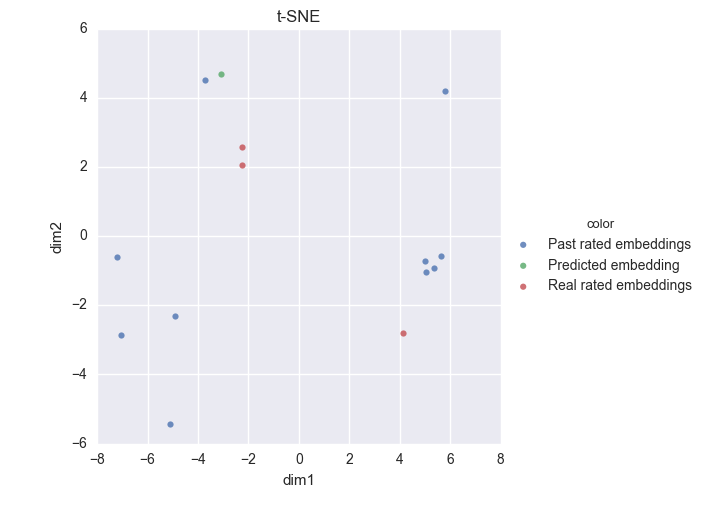

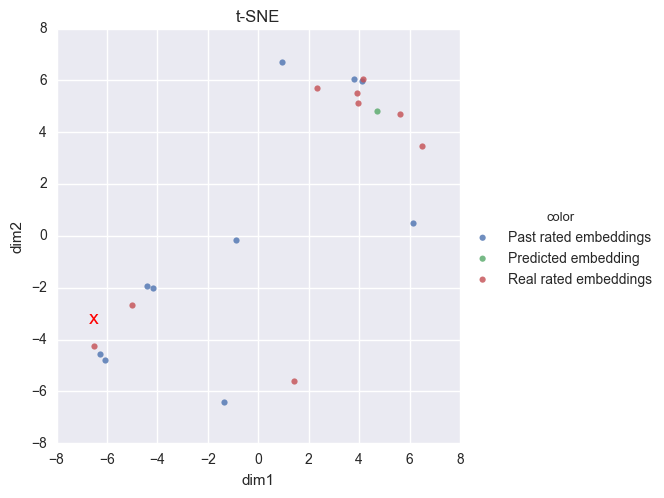

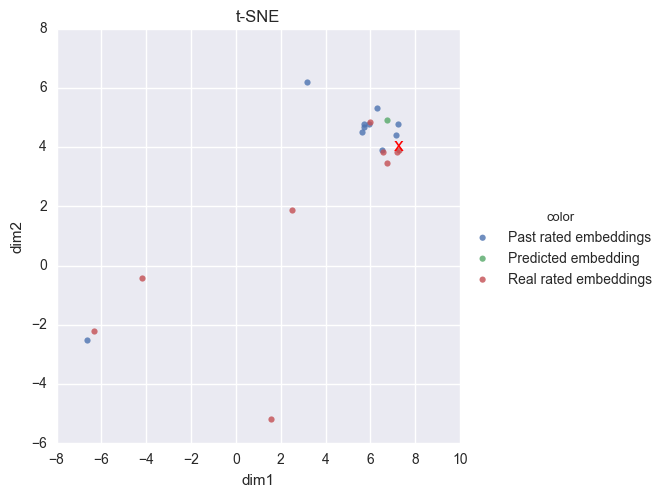

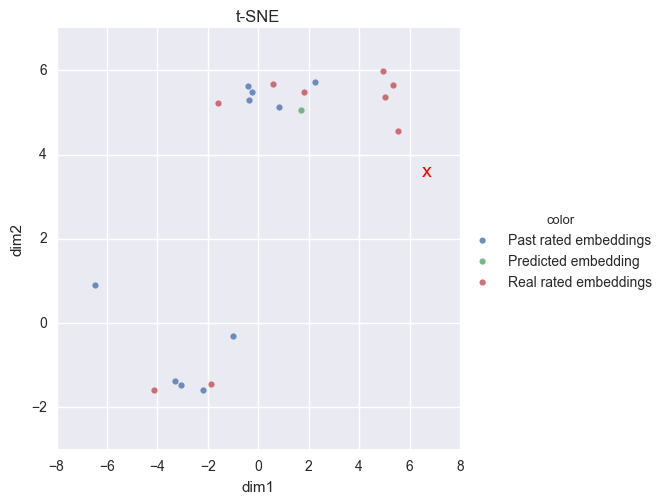

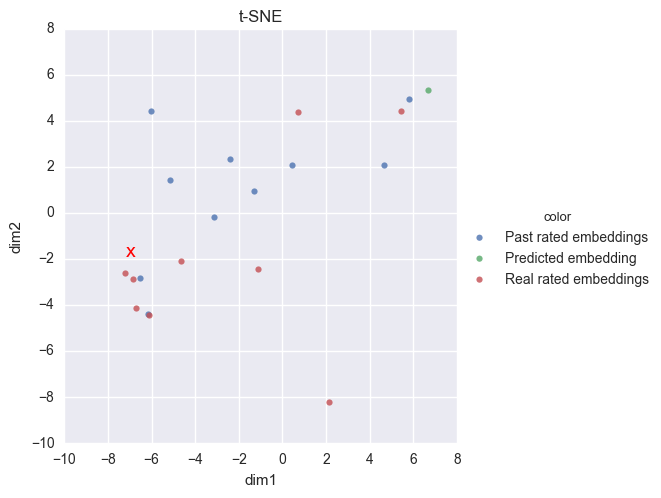

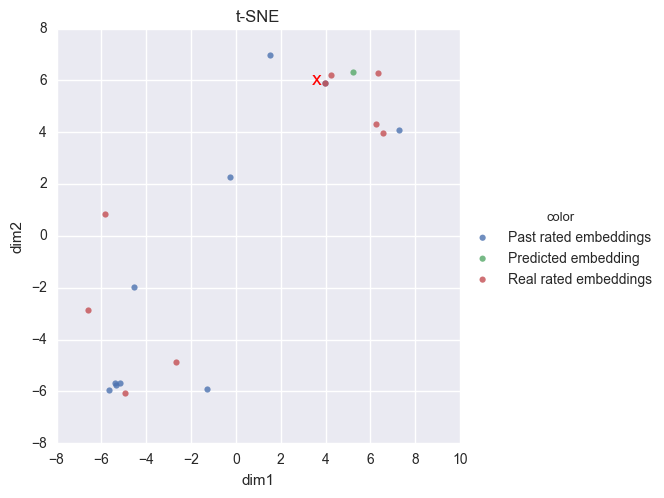

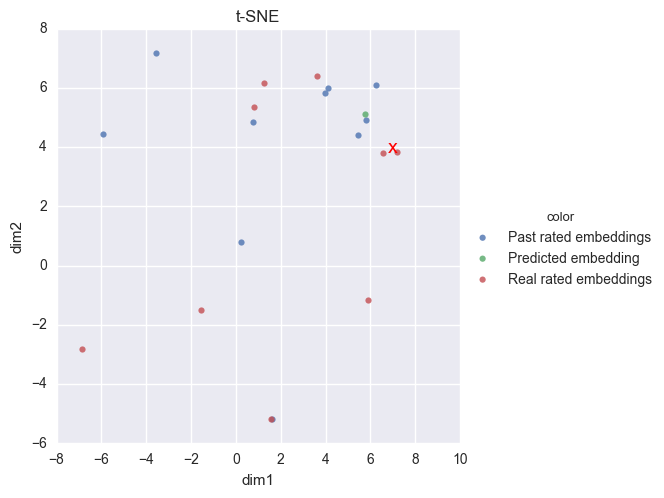

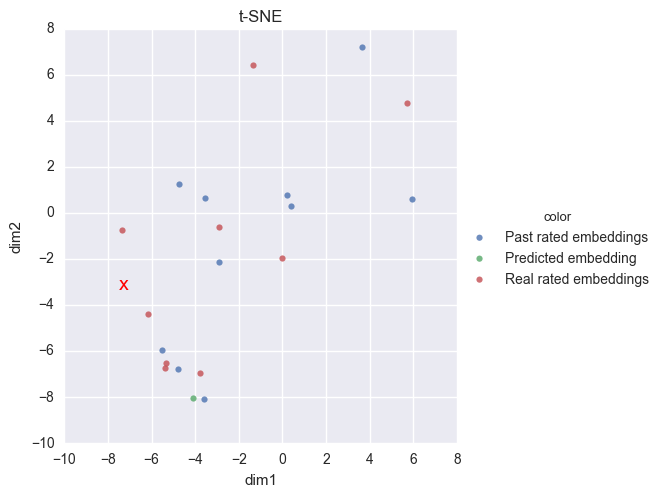

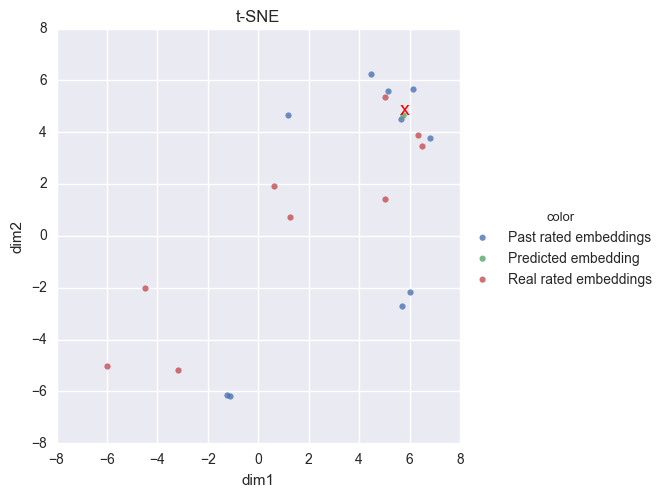

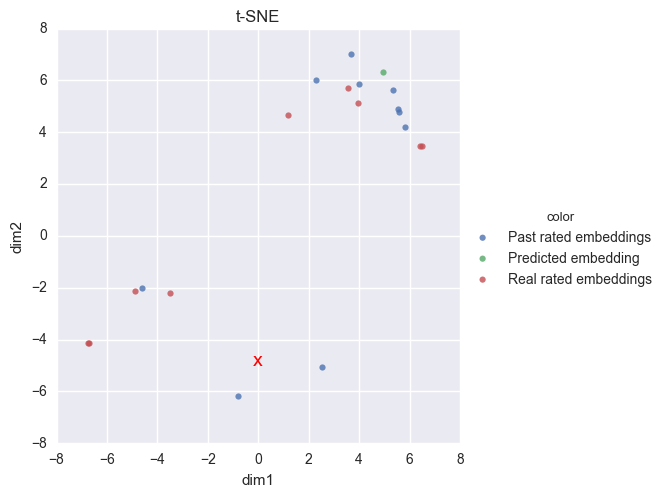

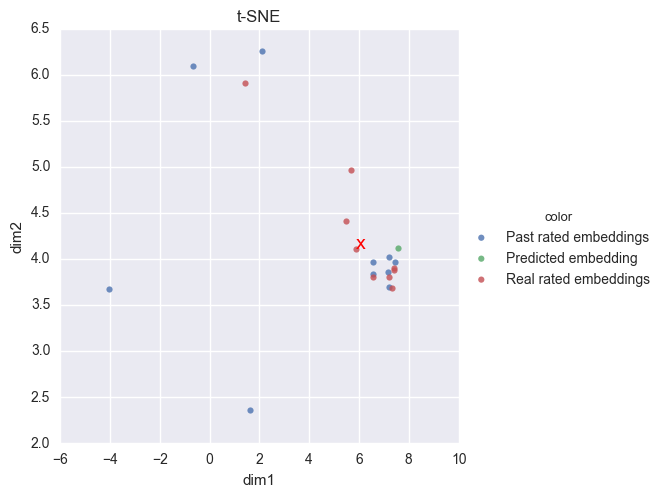

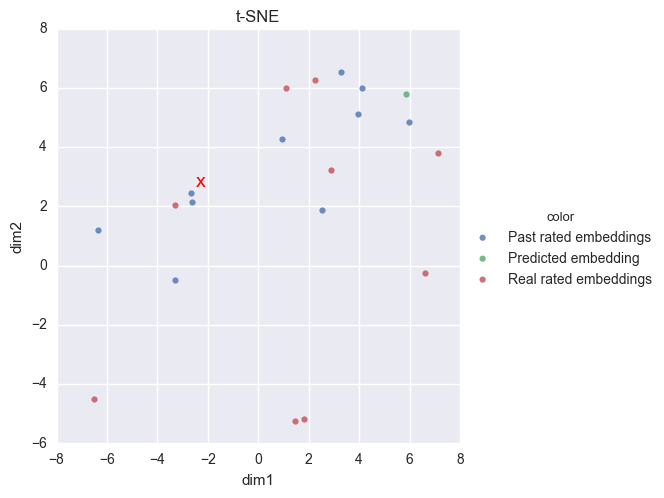

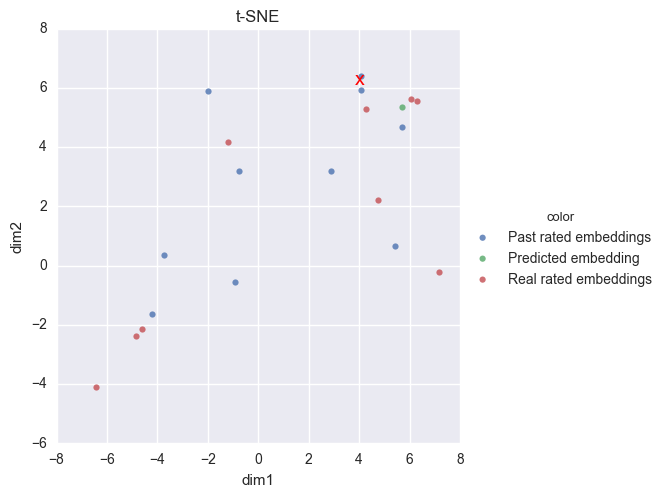

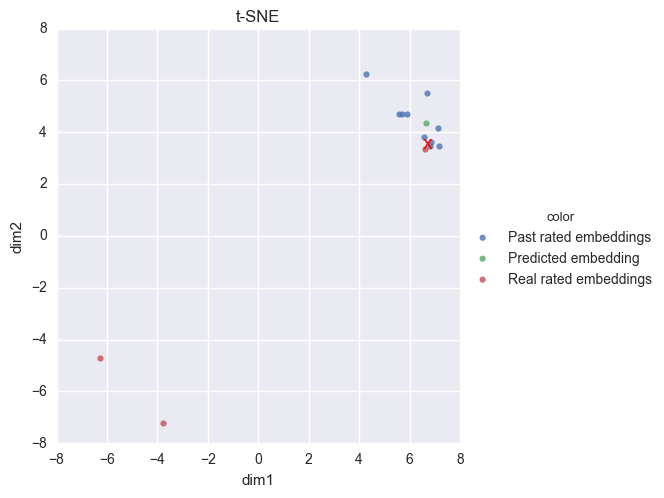

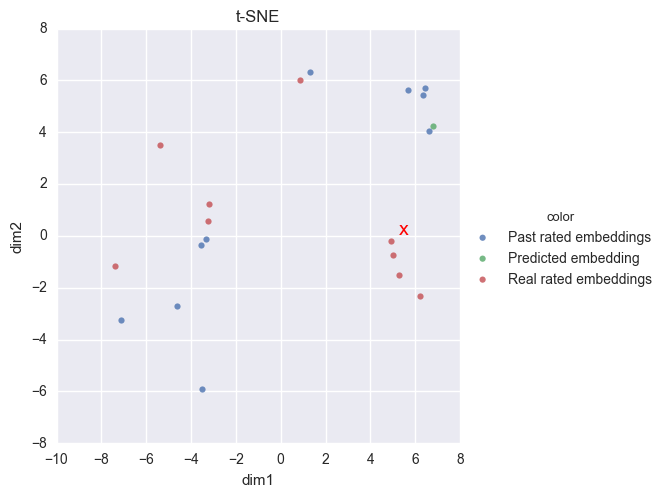

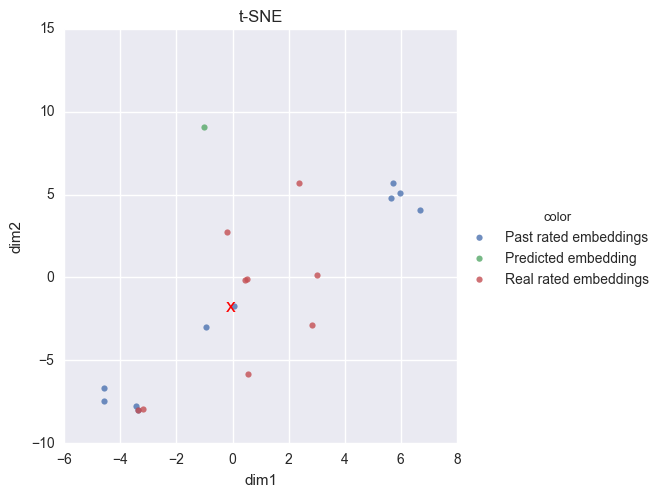

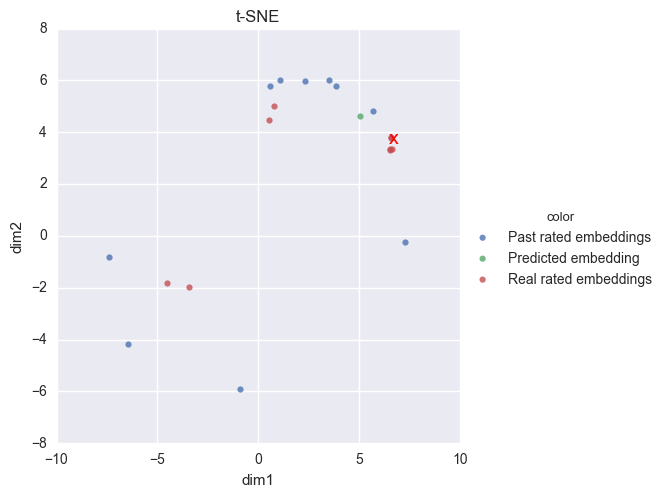

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


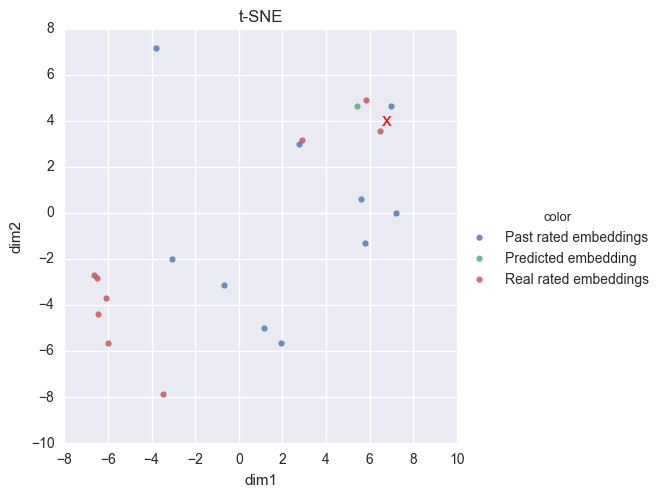

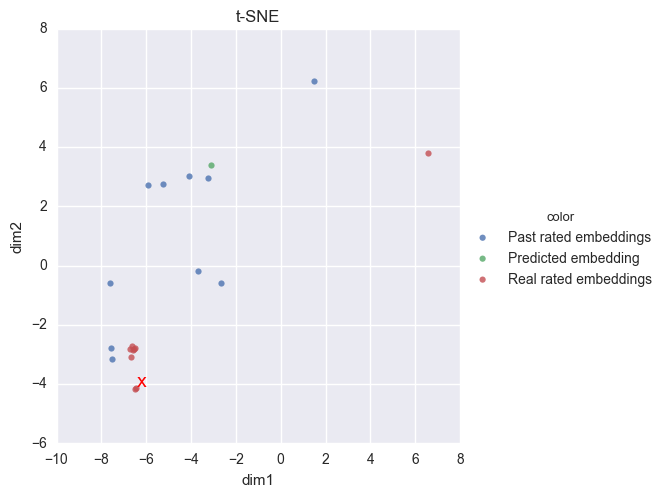

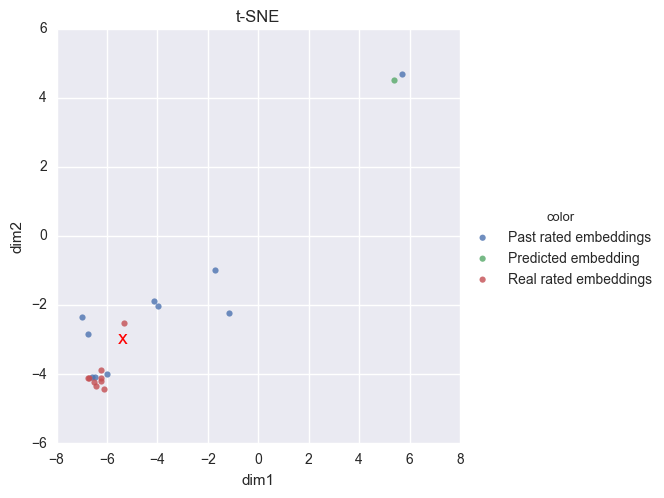

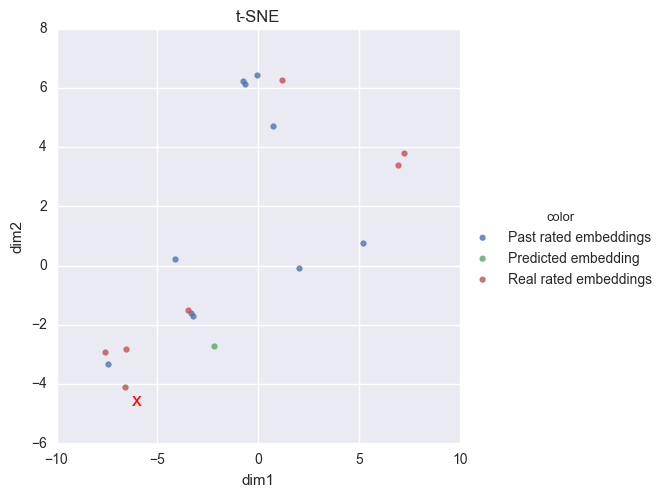

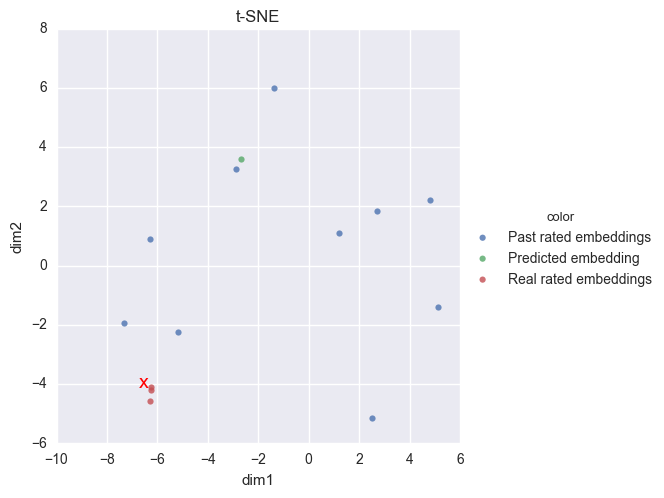

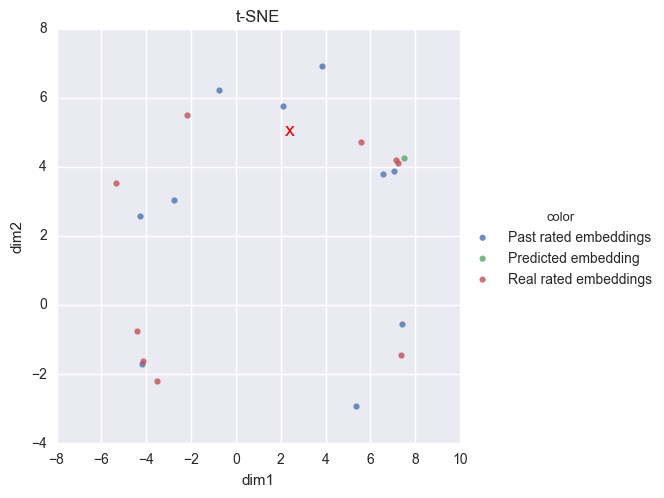

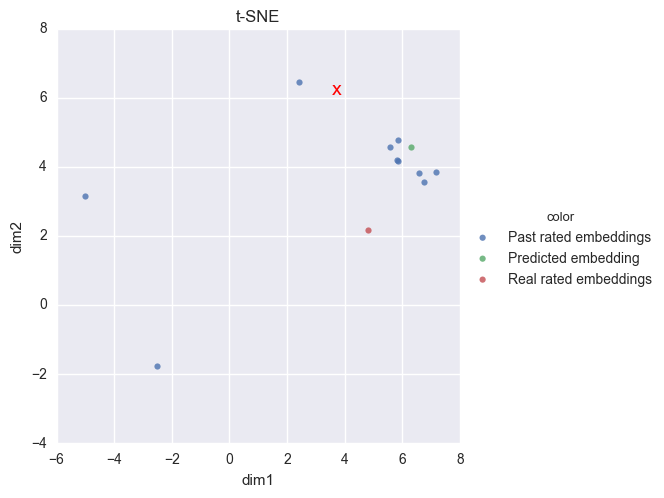

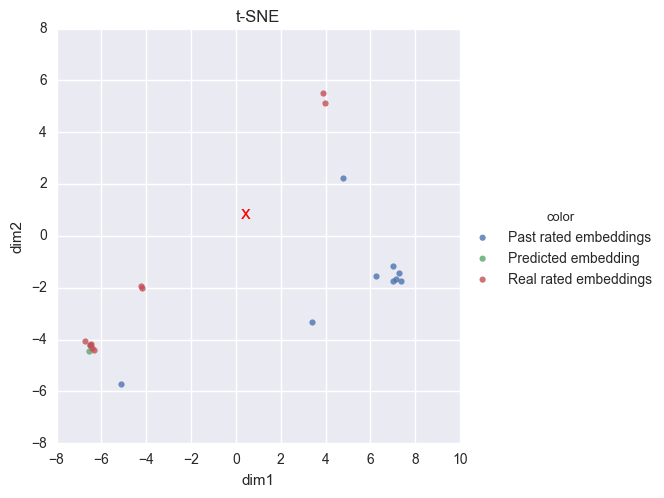

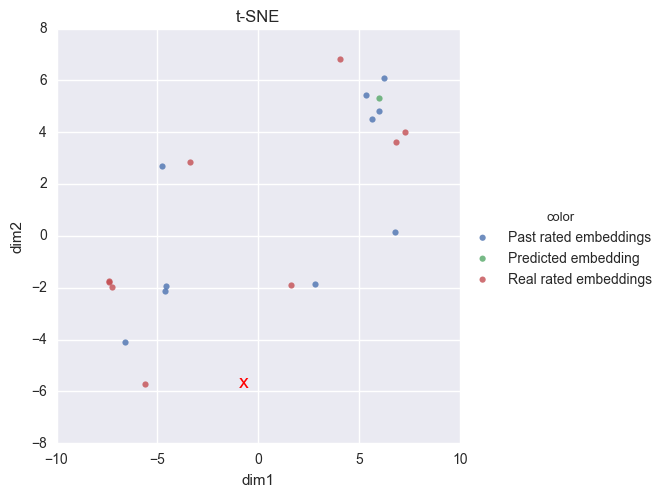

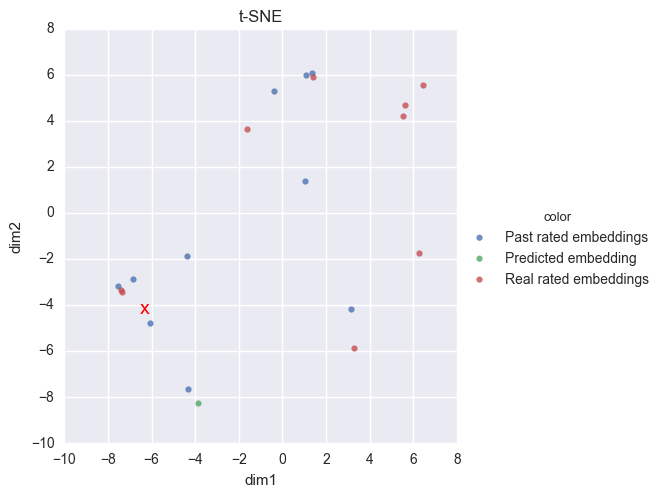

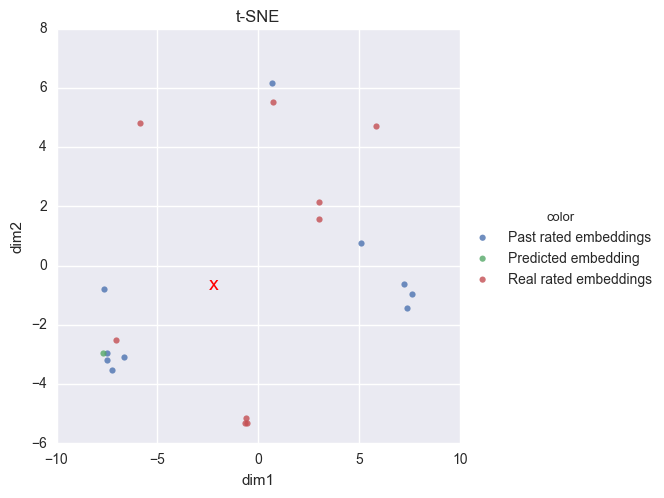

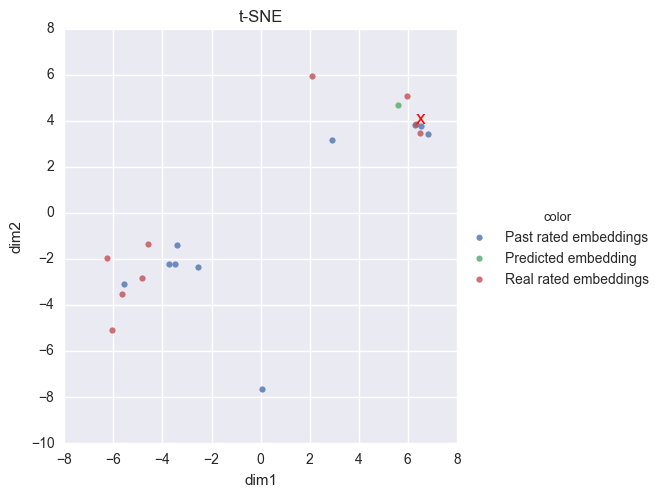

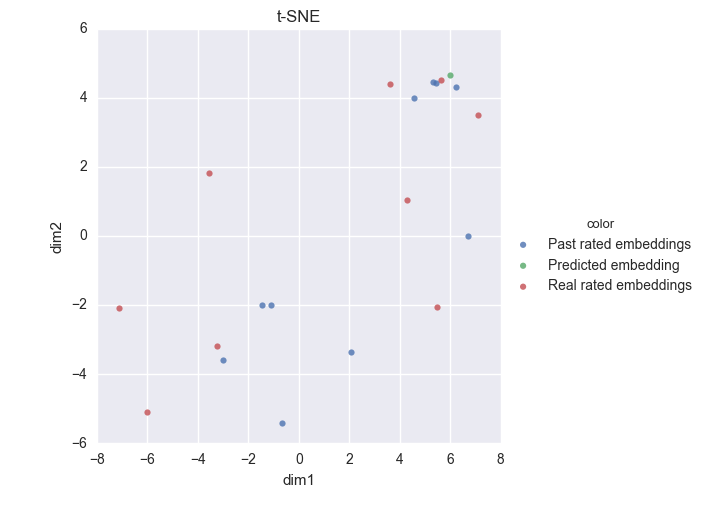

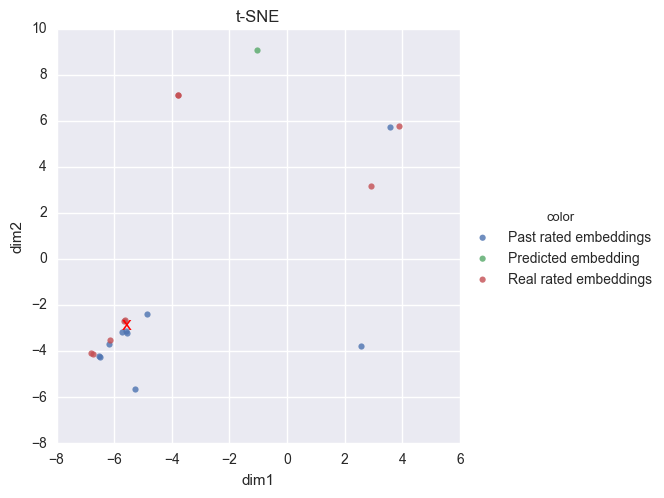

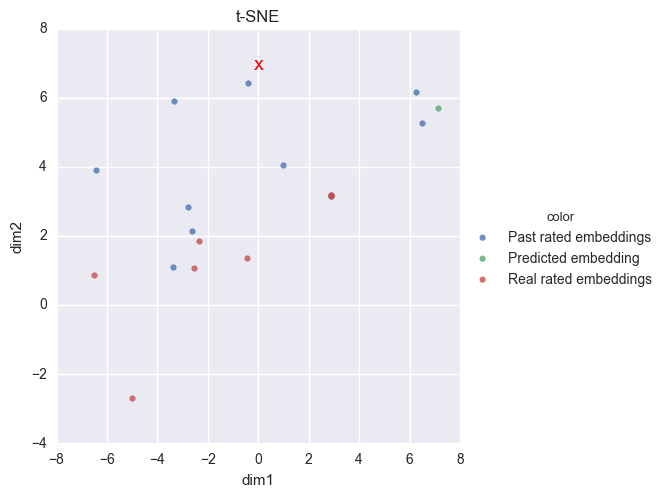

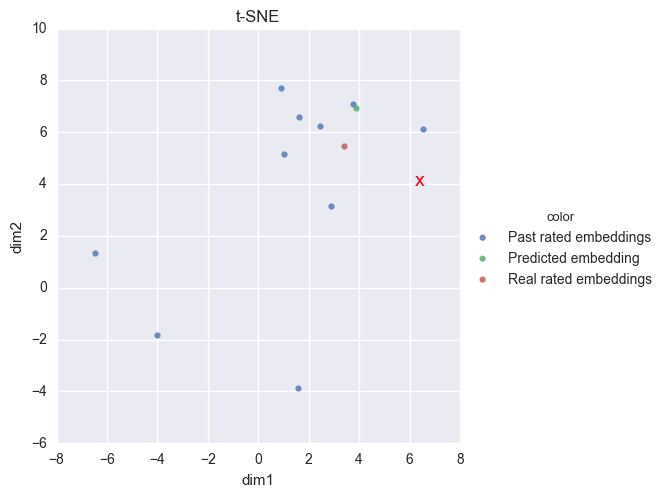

KeyboardInterrupt: 

In [40]:
# With all the embeddings
batch_size = 20
for i in range(0, len(X_test), batch_size):
    x_test = [x for x in X_test[i:i + batch_size]]
    y_test = [y.toarray() for y in Y_test[i:i + batch_size]]
    x_test2 = [x.toarray() for x in X_test2[i:i+batch_size]]
    logits, y_pred = model.predict(x_test, checkpoint_path)
    for j in range(len(y_pred)):
        # Retrain TSNE with new sample
        data_tsne_new = np.zeros((data_tsne.shape[0] + 1, data_tsne.shape[1]))
        data_tsne_new[0:(data_tsne.shape[0])] = data_tsne
        data_tsne_new[-1] = y_pred[j]
        model_tsn_new = TSNE(n_components=2, random_state=17)
        Y_tsn_new = model_tsn_new.fit_transform(data_tsne_new)
        # Obtain 2d embeddings of the input sequence
        embeddings_show = []
        embeddings_type = []
        _, l_already_watched = np.where(x_test2[j] == 1) 
        for one_hot_pos in l_already_watched[-10:]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            embeddings_show.append(Y_tsn_new[embedding_pos])
            embeddings_type.append('Past rated embeddings')
        # Obtain predicted embeddings
        embeddings_show.append(Y_tsn_new[-1])
        embeddings_type.append('Predicted embedding')
        # Obtain True embeddings
        _, y_true_idx = np.where(y_test[j] ==1)
        k = 0
        for one_hot_pos in y_true_idx[:10]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            if k == 0:
                #embeddings_type.append('First real rated embeddings')
                x_pos = Y_tsn_new[embedding_pos][0]
                y_pos = Y_tsn_new[embedding_pos][1]
            else:
                embeddings_show.append(Y_tsn_new[embedding_pos])
                embeddings_type.append('Real rated embeddings')
            k = k + 1
        # Create dataframe to show
        df_show = pd.DataFrame(np.array(embeddings_show))
        df_show.columns = ['x', 'y']
        df_show['type_embedding'] = embeddings_type
        df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['type_embedding']))
        ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
        ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=14, color='red')
        plt.title('t-SNE')
        plt.show()
        #break
    #break

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


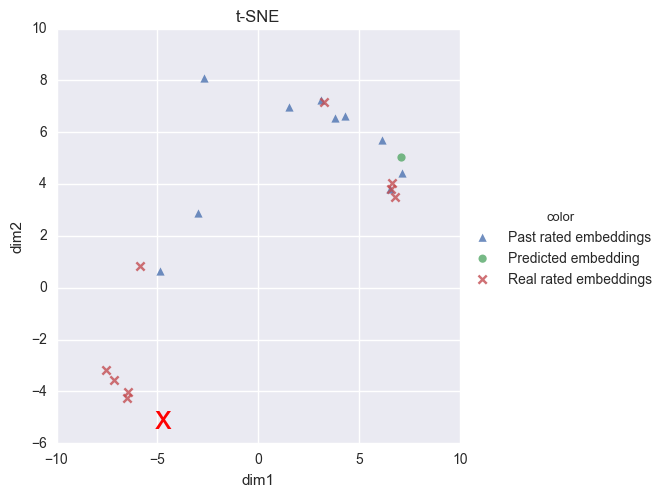

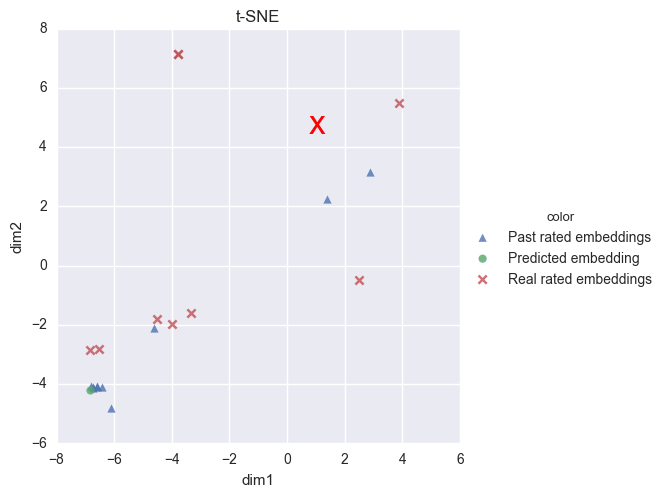

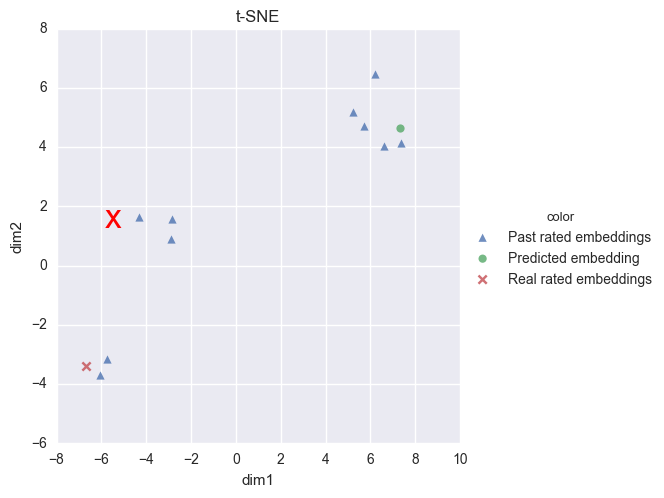

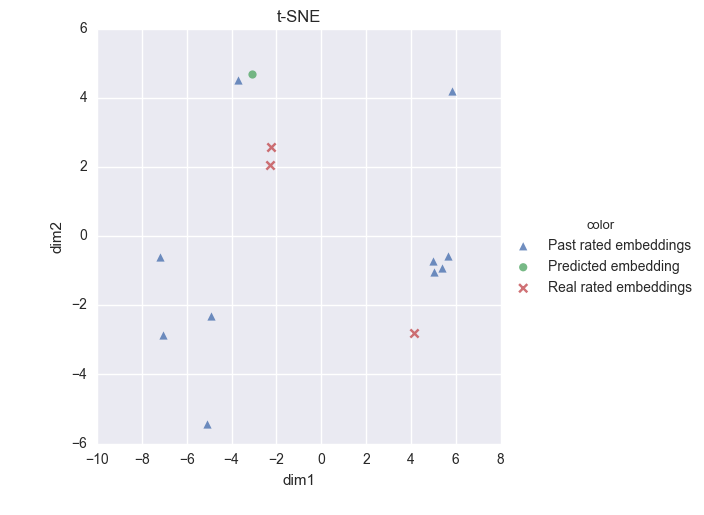

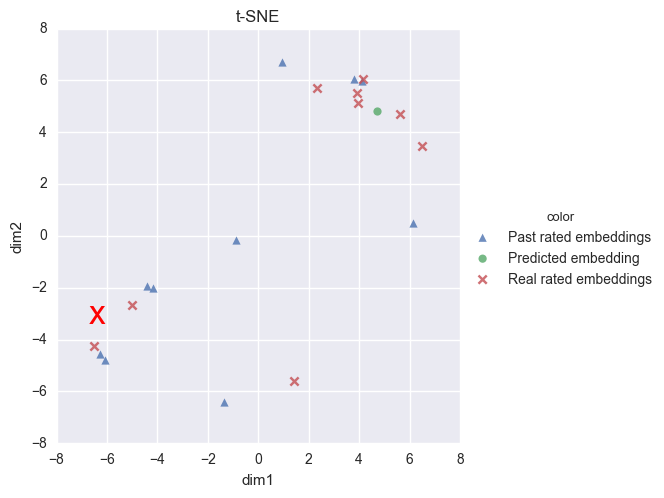

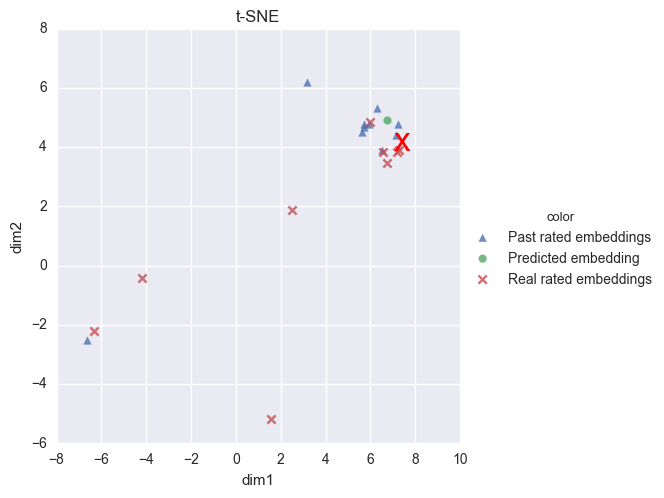

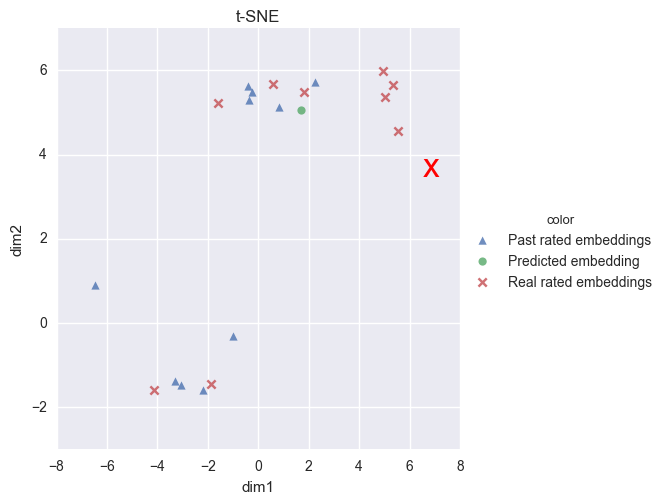

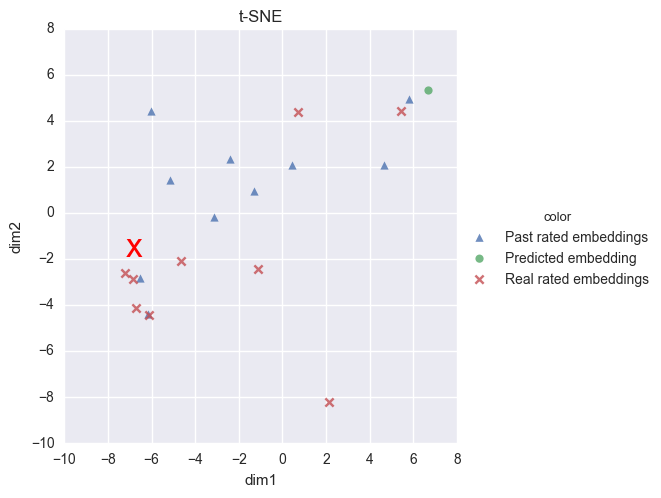

KeyboardInterrupt: 

In [50]:
# With all the embeddings
batch_size = 20
for i in range(0, len(X_test), batch_size):
    x_test = [x for x in X_test[i:i + batch_size]]
    y_test = [y.toarray() for y in Y_test[i:i + batch_size]]
    x_test2 = [x.toarray() for x in X_test2[i:i+batch_size]]
    logits, y_pred = model.predict(x_test, checkpoint_path)
    for j in range(len(y_pred)):
        # Retrain TSNE with new sample
        data_tsne_new = np.zeros((data_tsne.shape[0] + 1, data_tsne.shape[1]))
        data_tsne_new[0:(data_tsne.shape[0])] = data_tsne
        data_tsne_new[-1] = y_pred[j]
        model_tsn_new = TSNE(n_components=2, random_state=17)
        Y_tsn_new = model_tsn_new.fit_transform(data_tsne_new)
        # Obtain 2d embeddings of the input sequence
        embeddings_show = []
        embeddings_type = []
        _, l_already_watched = np.where(x_test2[j] == 1) 
        for one_hot_pos in l_already_watched[-10:]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            embeddings_show.append(Y_tsn_new[embedding_pos])
            embeddings_type.append('Past rated embeddings')
        # Obtain predicted embeddings
        embeddings_show.append(Y_tsn_new[-1])
        embeddings_type.append('Predicted embedding')
        # Obtain True embeddings
        _, y_true_idx = np.where(y_test[j] ==1)
        k = 0
        for one_hot_pos in y_true_idx[:10]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            if k == 0:
                #embeddings_type.append('First real rated embeddings')
                x_pos = Y_tsn_new[embedding_pos][0]
                y_pos = Y_tsn_new[embedding_pos][1]
            else:
                embeddings_show.append(Y_tsn_new[embedding_pos])
                embeddings_type.append('Real rated embeddings')
            k = k + 1
        # Create dataframe to show
        df_show = pd.DataFrame(np.array(embeddings_show))
        df_show.columns = ['x', 'y']
        df_show['type_embedding'] = embeddings_type
        df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['type_embedding']))
        ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, markers=["^", "o", "x"], scatter_kws={"s": 35})
        ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=24, color='red')
        plt.title('t-SNE')
        plt.show()
        #break
    #break

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


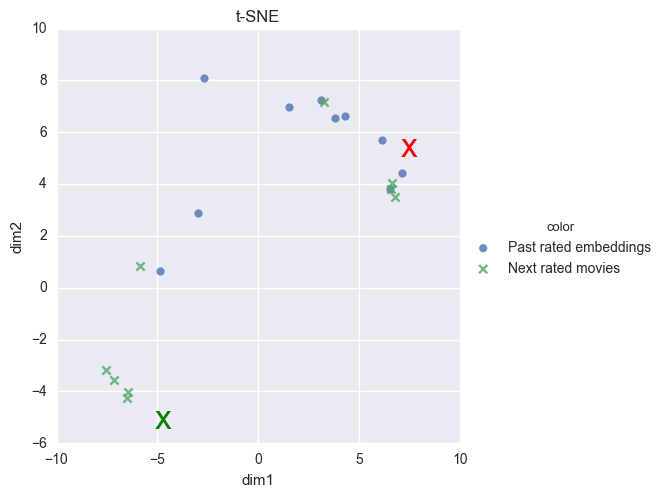

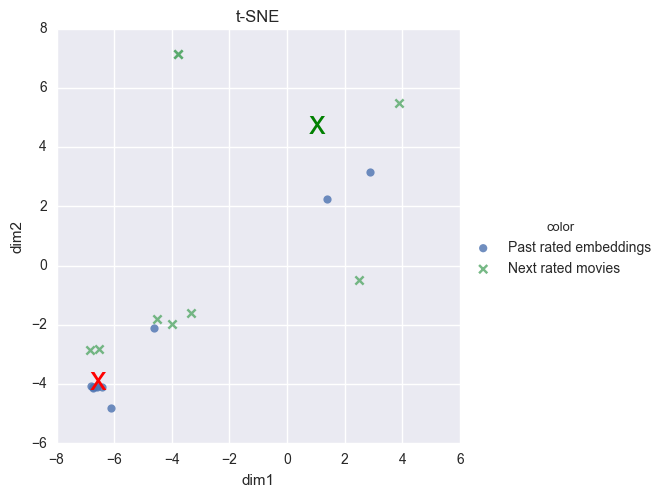

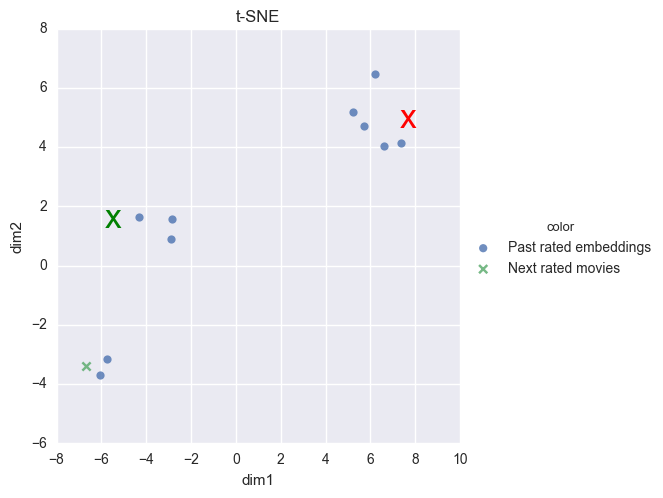

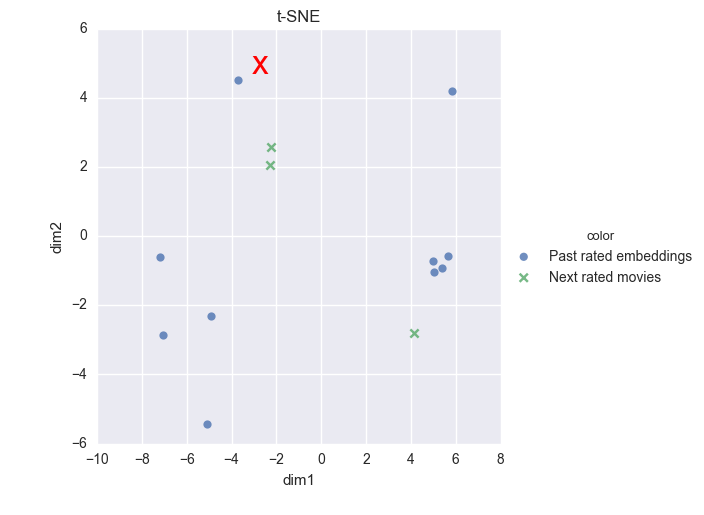

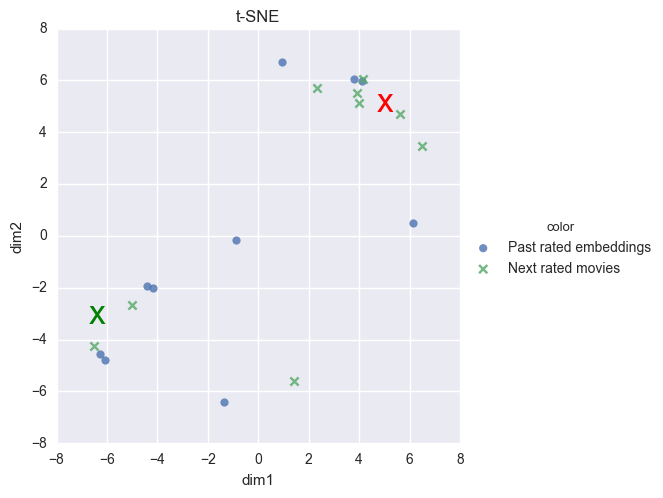

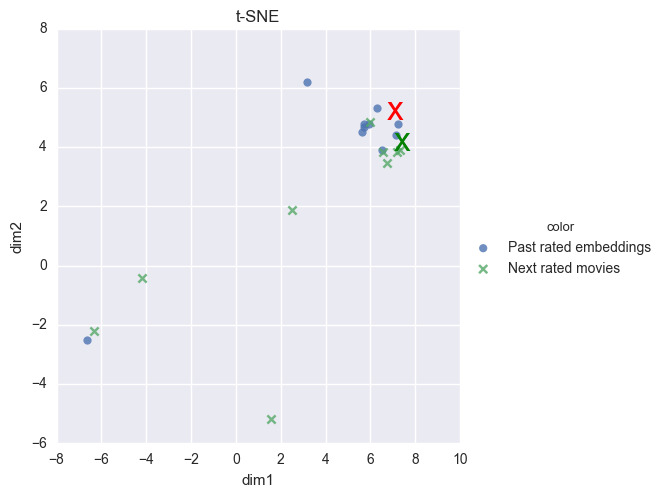

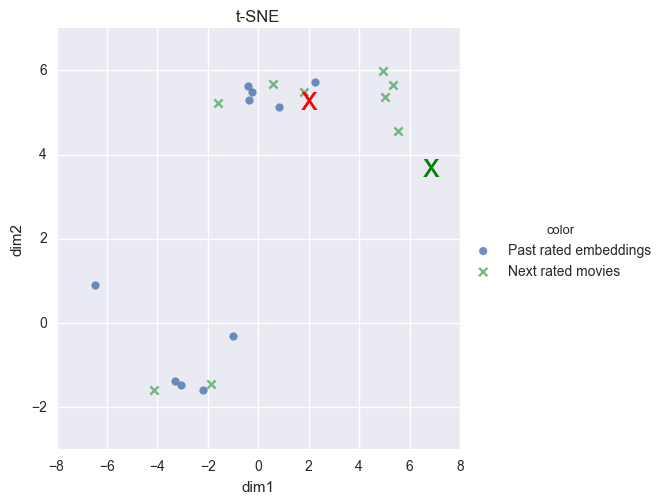

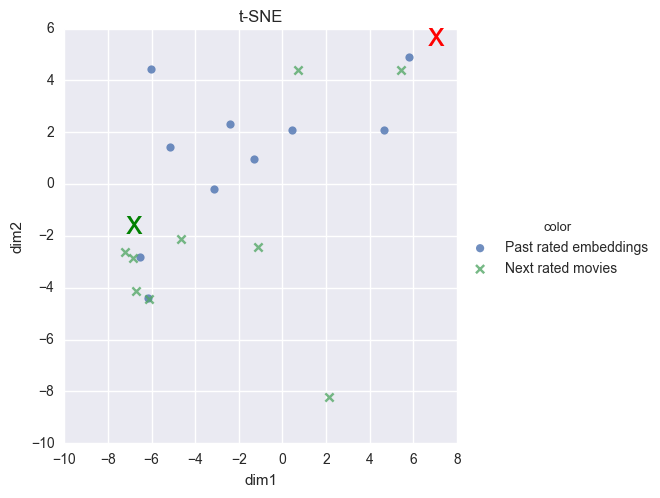

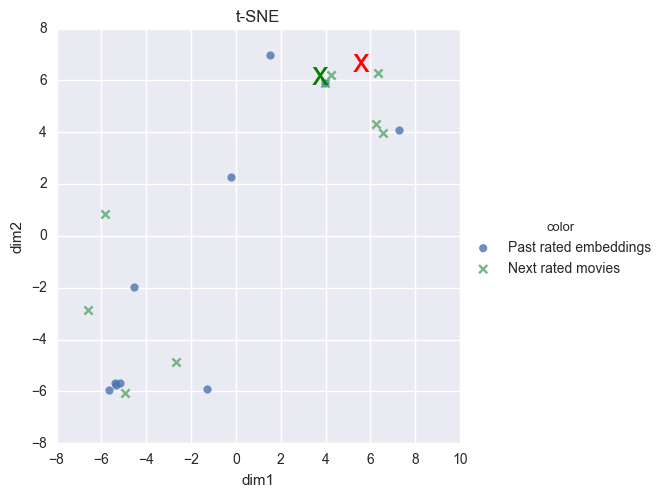

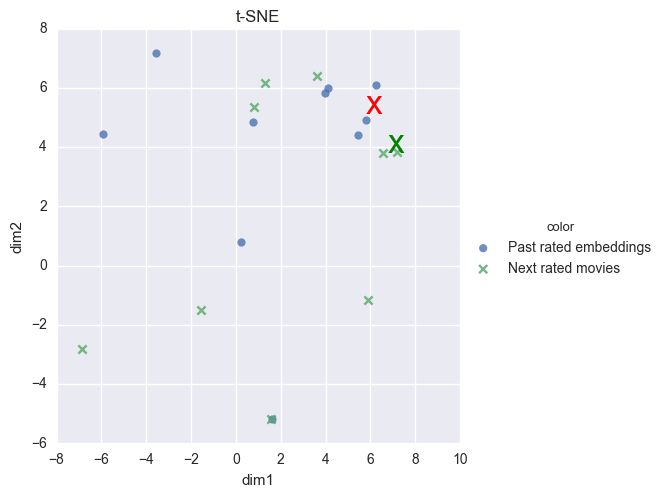

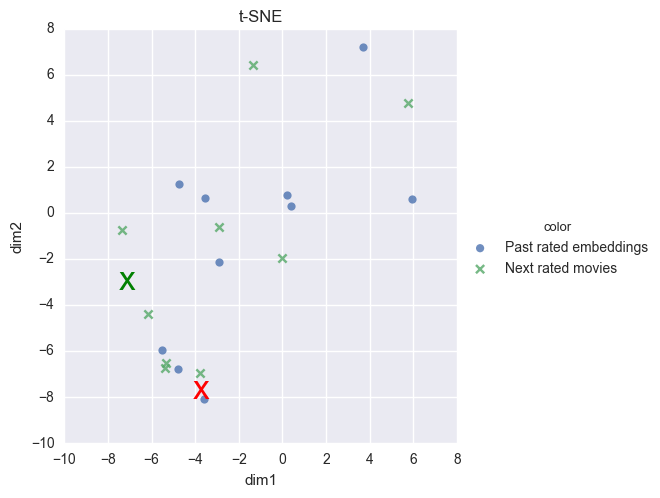

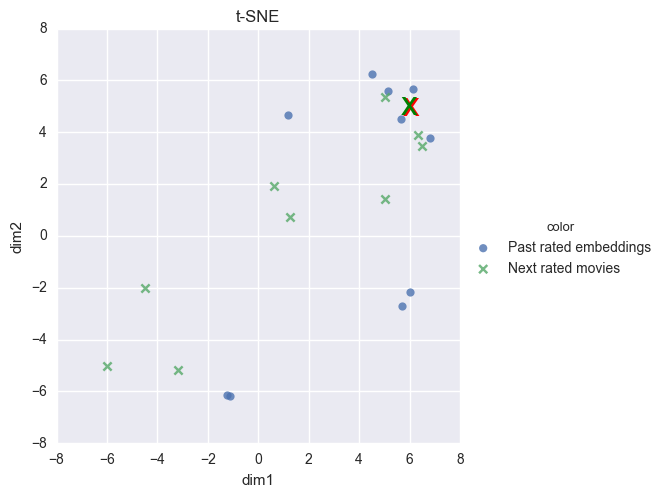

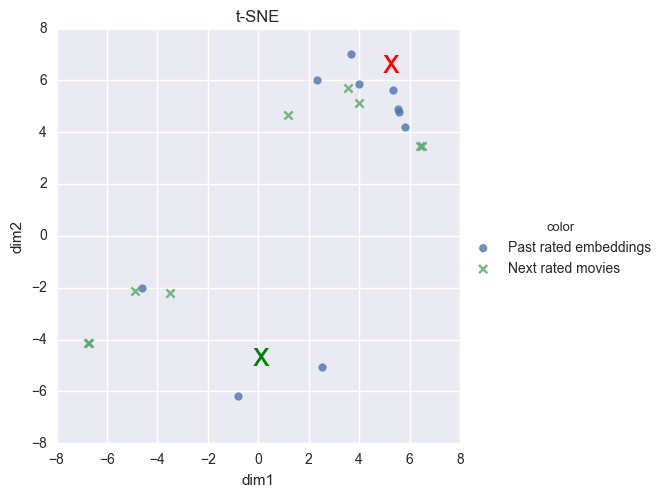

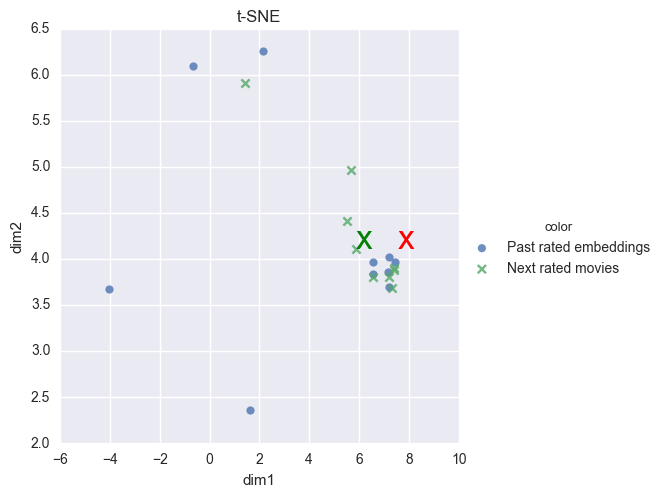

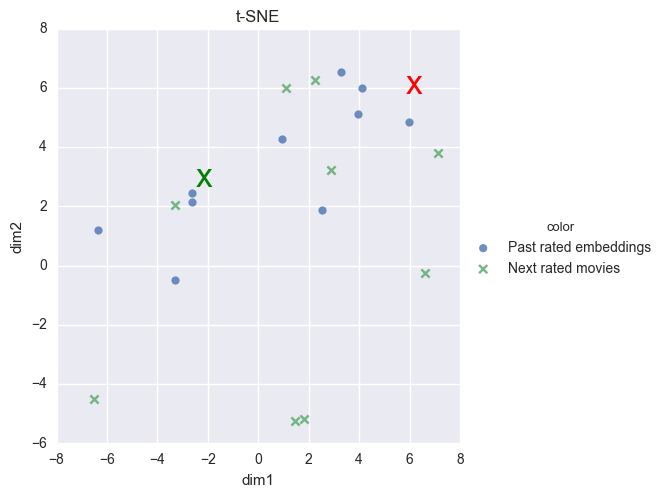

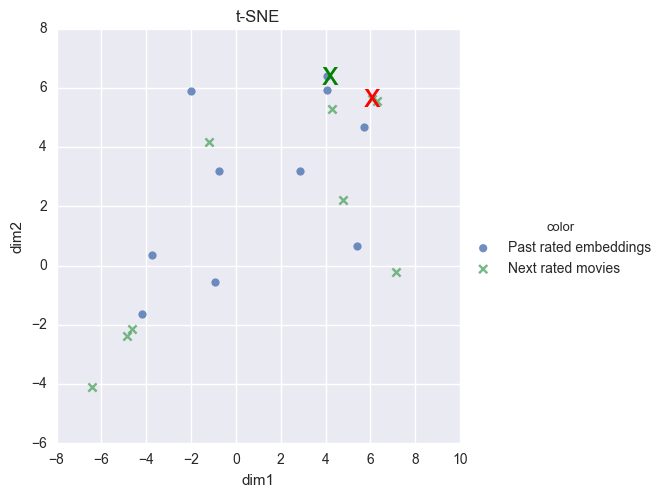

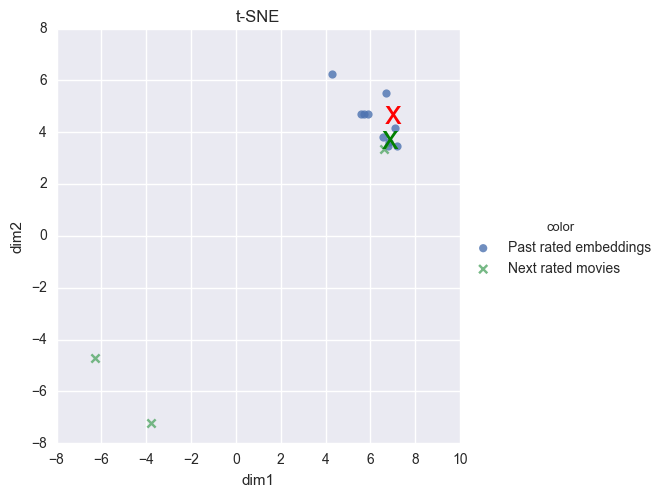

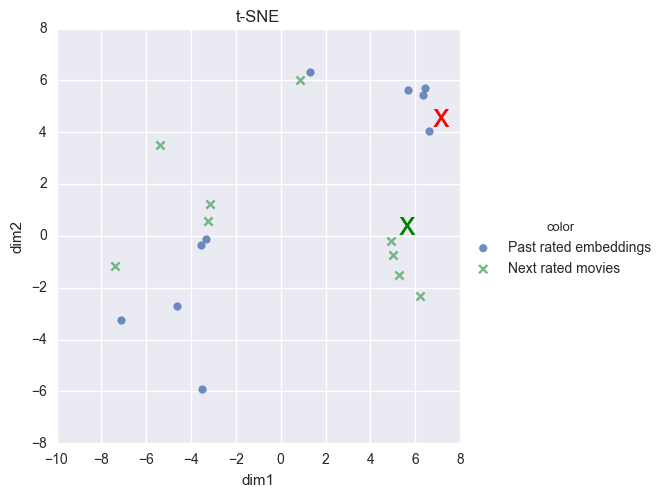

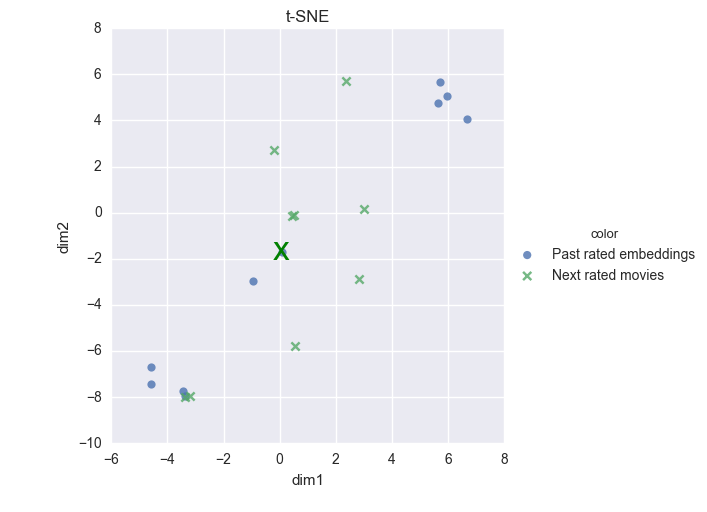

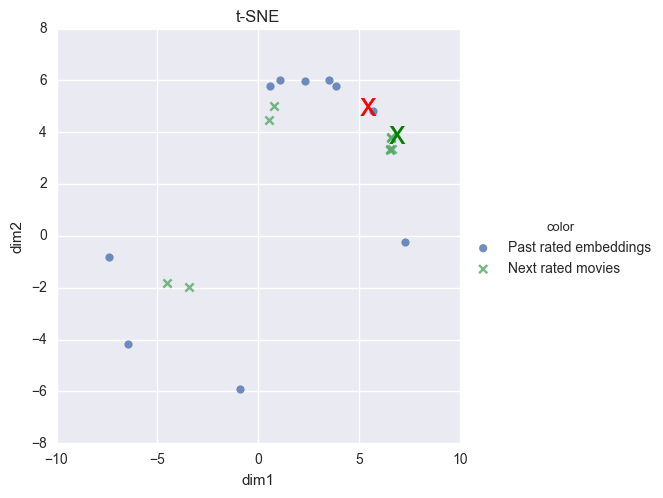

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


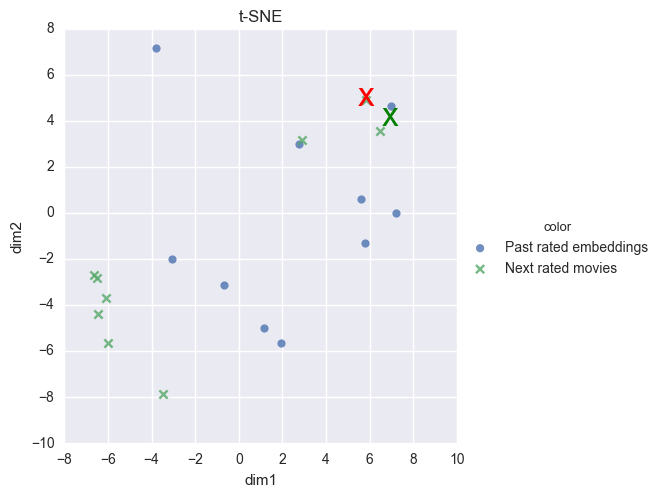

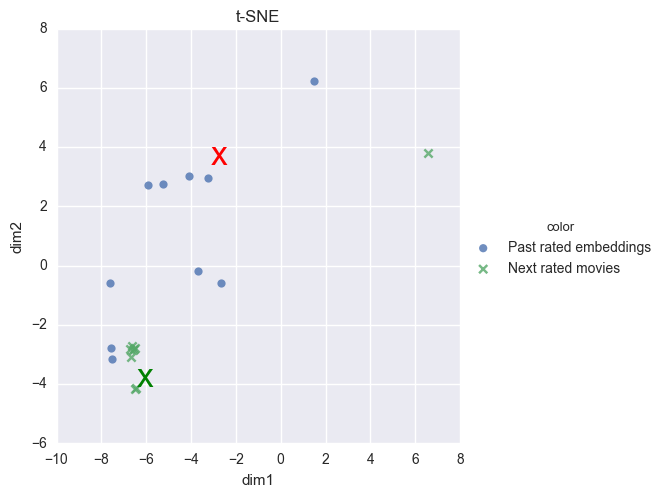

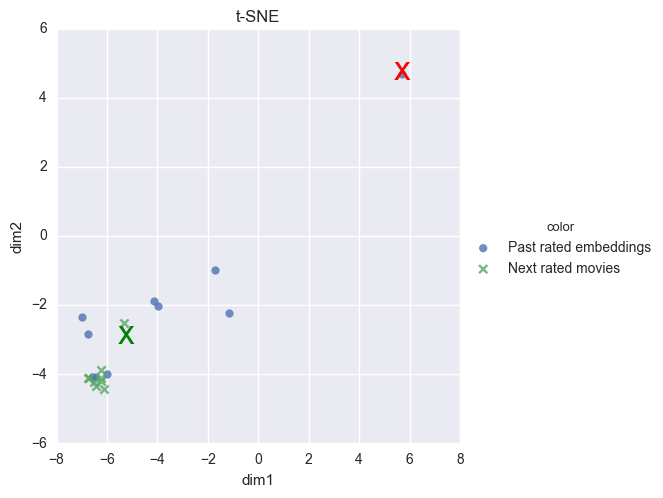

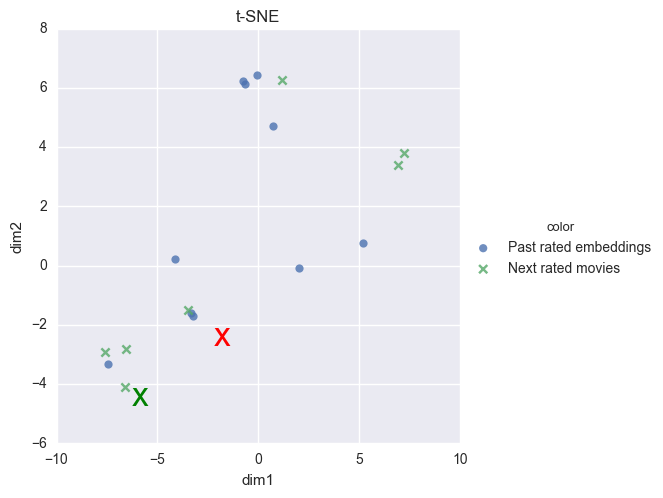

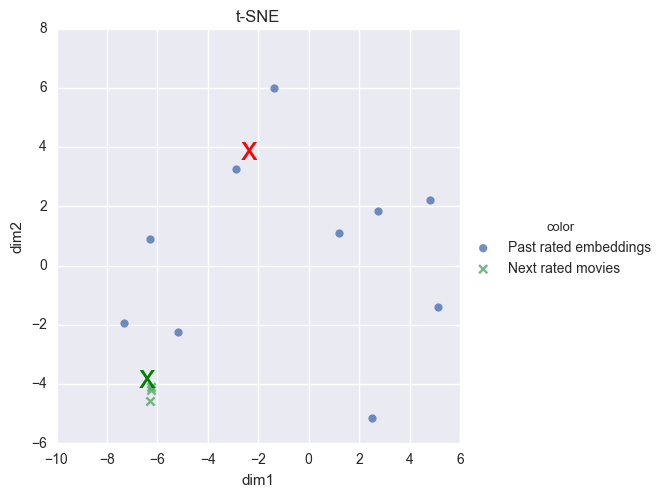

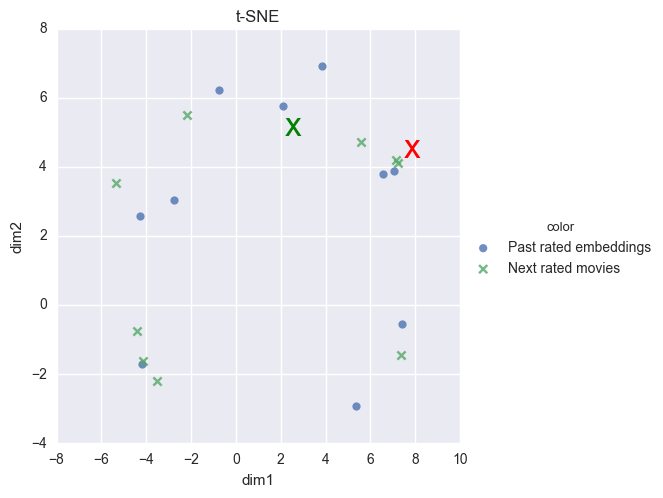

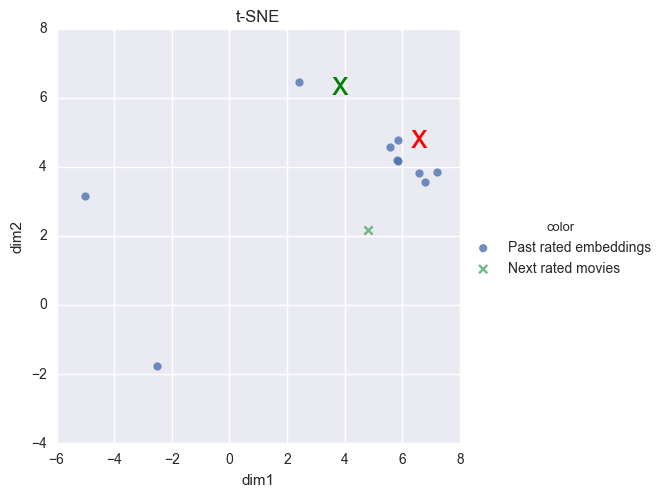

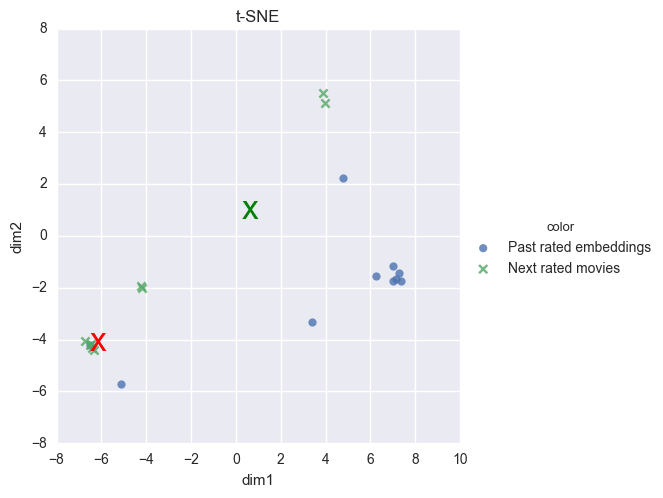

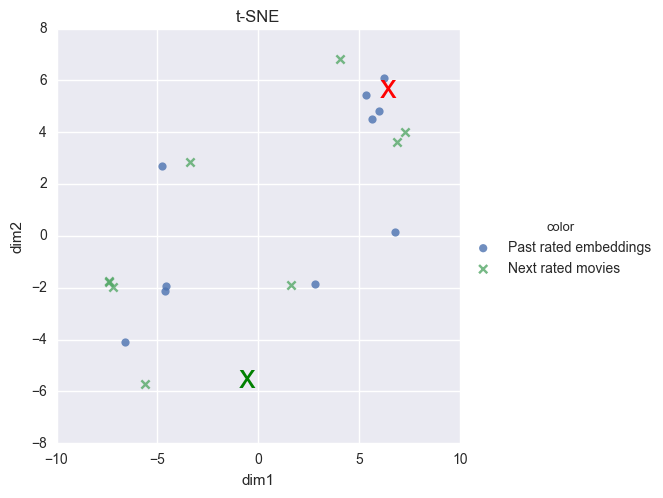

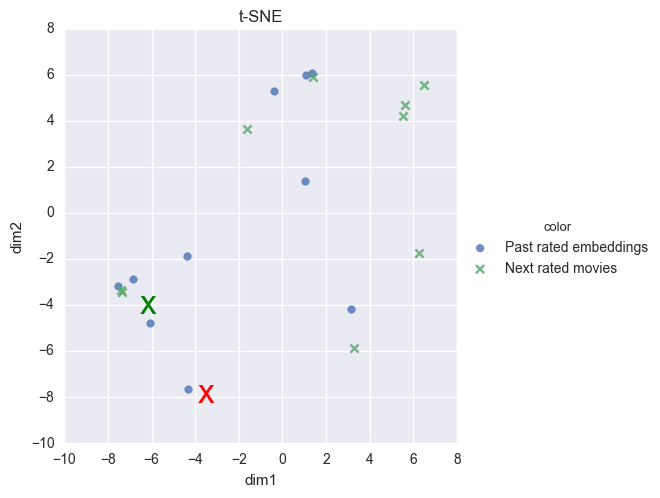

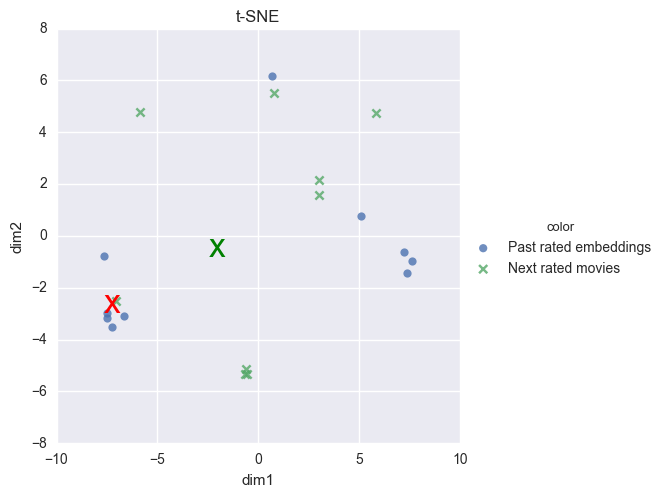

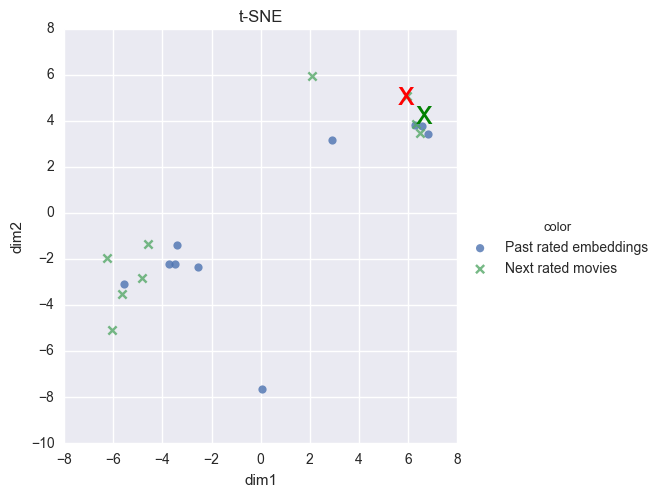

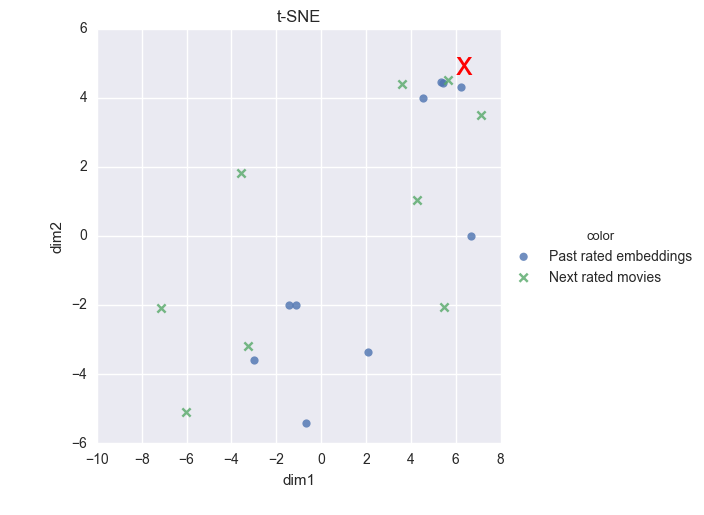

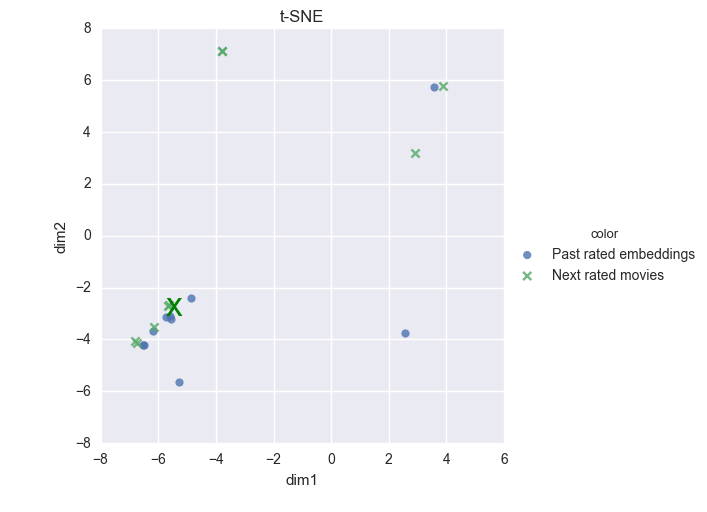

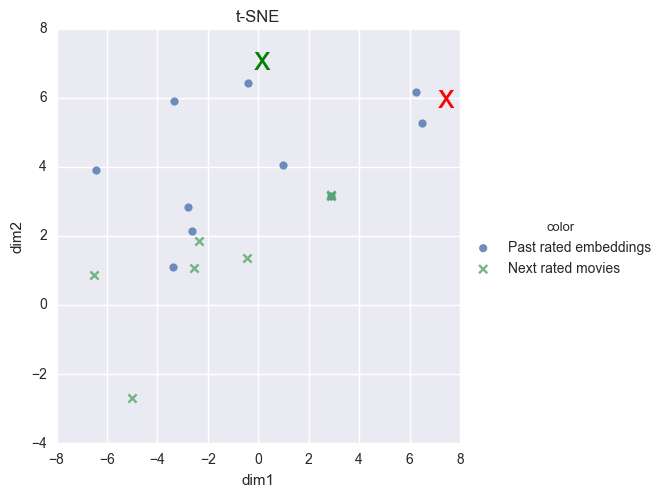

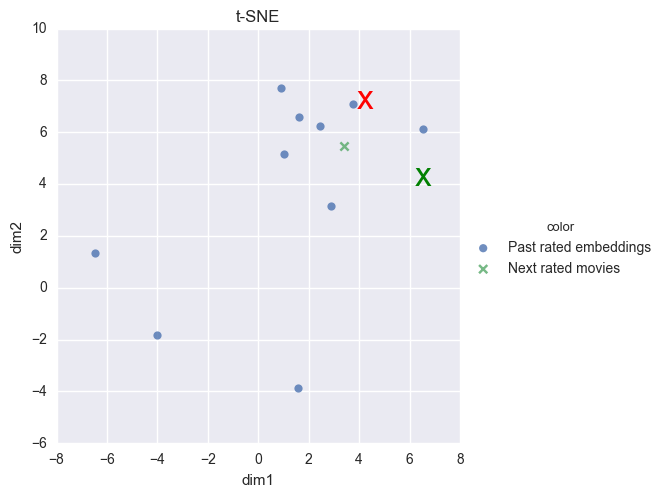

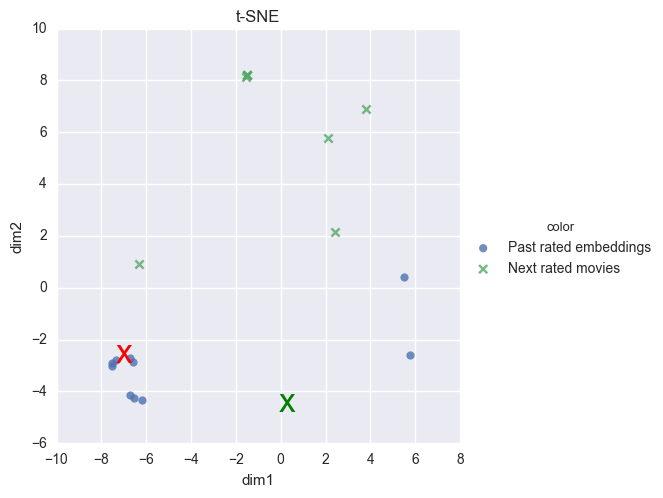

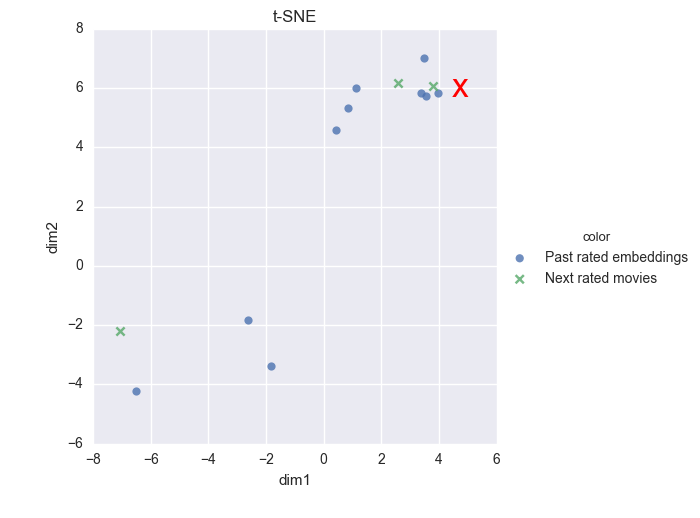

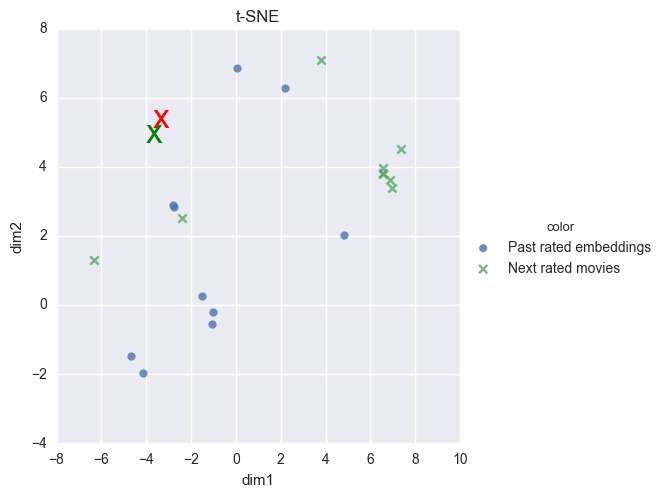

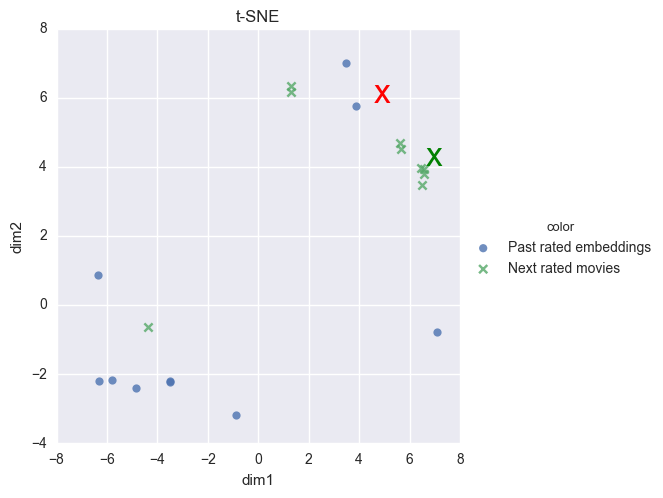

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000


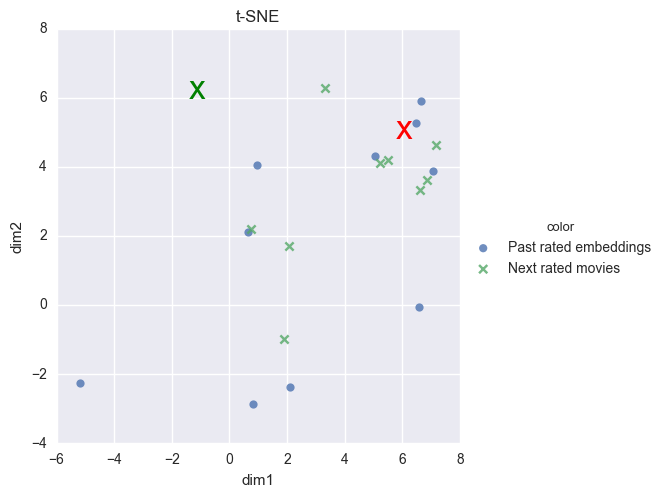

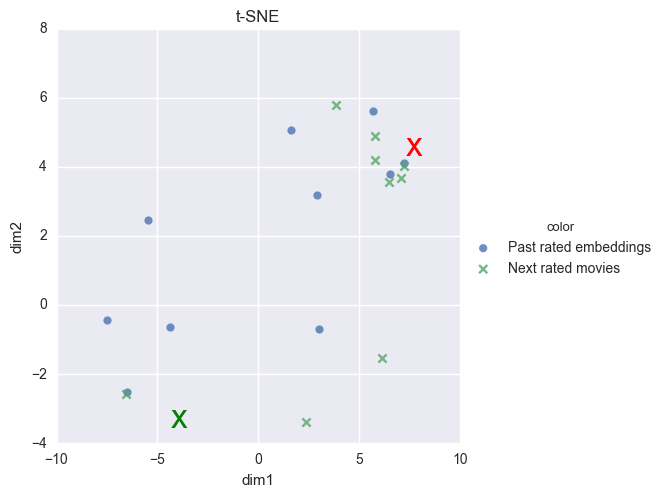

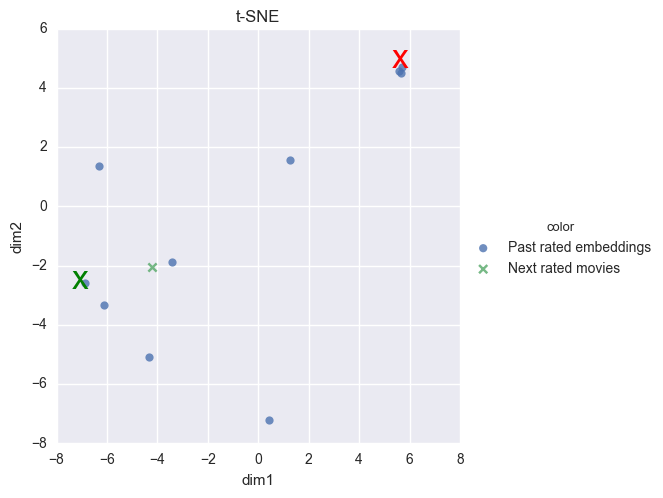

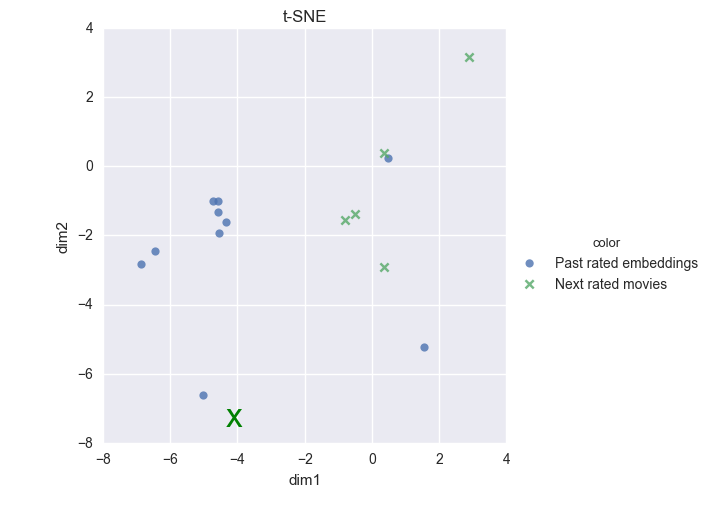

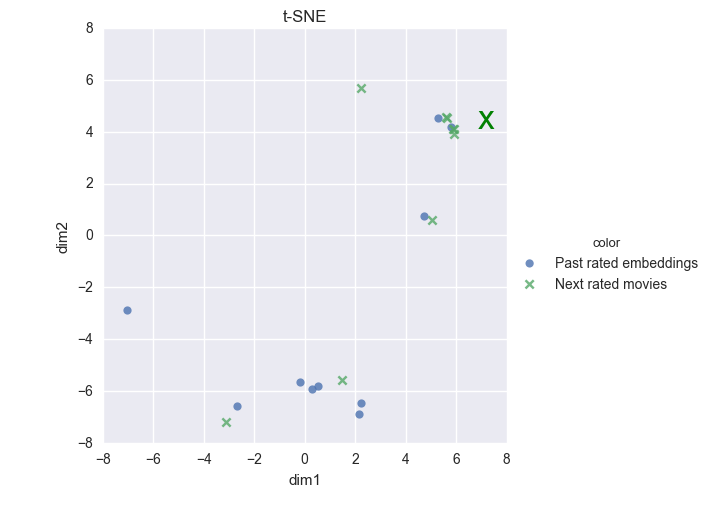

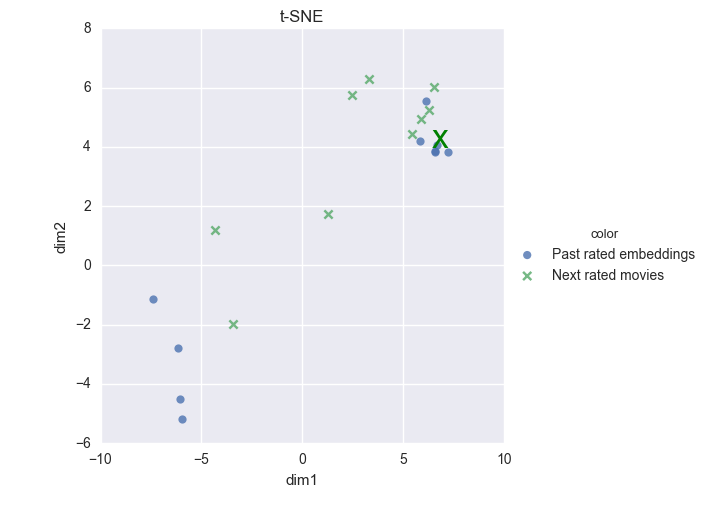

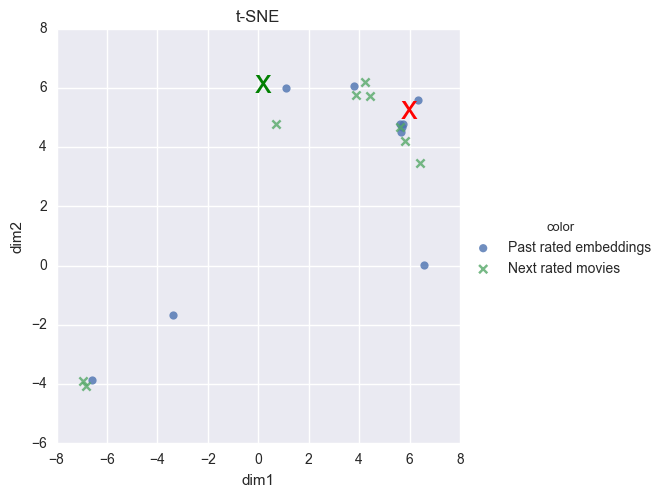

KeyboardInterrupt: 

In [55]:
# With all the embeddings
batch_size = 20
for i in range(0, len(X_test), batch_size):
    x_test = [x for x in X_test[i:i + batch_size]]
    y_test = [y.toarray() for y in Y_test[i:i + batch_size]]
    x_test2 = [x.toarray() for x in X_test2[i:i+batch_size]]
    logits, y_pred = model.predict(x_test, checkpoint_path)
    for j in range(len(y_pred)):
        # Retrain TSNE with new sample
        data_tsne_new = np.zeros((data_tsne.shape[0] + 1, data_tsne.shape[1]))
        data_tsne_new[0:(data_tsne.shape[0])] = data_tsne
        data_tsne_new[-1] = y_pred[j]
        model_tsn_new = TSNE(n_components=2, random_state=17)
        Y_tsn_new = model_tsn_new.fit_transform(data_tsne_new)
        # Obtain 2d embeddings of the input sequence
        embeddings_show = []
        embeddings_type = []
        _, l_already_watched = np.where(x_test2[j] == 1) 
        for one_hot_pos in l_already_watched[-10:]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            embeddings_show.append(Y_tsn_new[embedding_pos])
            embeddings_type.append('Past rated embeddings')
        # Obtain predicted embeddings
        #embeddings_show.append(Y_tsn_new[-1])
        #embeddings_type.append('Predicted embedding')
        x_pos = Y_tsn_new[-1][0]
        y_pos = Y_tsn_new[-1][1]
        # Obtain True embeddings
        _, y_true_idx = np.where(y_test[j] ==1)
        k = 0
        for one_hot_pos in y_true_idx[:10]:
            movie_id = dict_movies[one_hot_pos]
            embedding_pos = dict_movieId_pos[str(movie_id)]
            if k == 0:
                #embeddings_show.append(Y_tsn_new[embedding_pos])
                #embeddings_type.append('First next rated movie')
                x_pos_2 = Y_tsn_new[embedding_pos][0]
                y_pos_2 = Y_tsn_new[embedding_pos][1]
            else:
                embeddings_show.append(Y_tsn_new[embedding_pos])
                embeddings_type.append('Next rated movies')
            k = k + 1
        # Create dataframe to show
        df_show = pd.DataFrame(np.array(embeddings_show))
        df_show.columns = ['x', 'y']
        df_show['type_embedding'] = embeddings_type
        df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['type_embedding']))
        ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, markers=["o", "x"], scatter_kws={"s": 35})
        ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=24, color='red')
        ax.fig.axes[0].annotate('x', (x_pos_2, y_pos_2), fontsize=24, color='green')
        plt.title('t-SNE')
        plt.show()
        #break
    #break

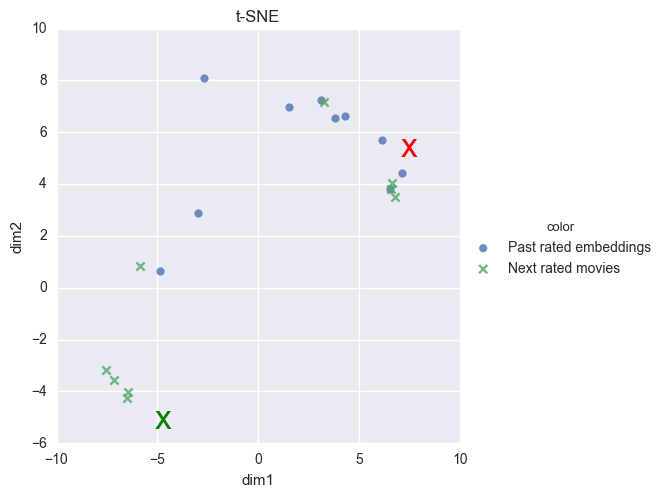

In [54]:
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, markers=["o", "x"], scatter_kws={"s": 35})
ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=24, color='red')
ax.fig.axes[0].annotate('x', (x_pos_2, y_pos_2), fontsize=24, color='green')
plt.title('t-SNE')
plt.show()

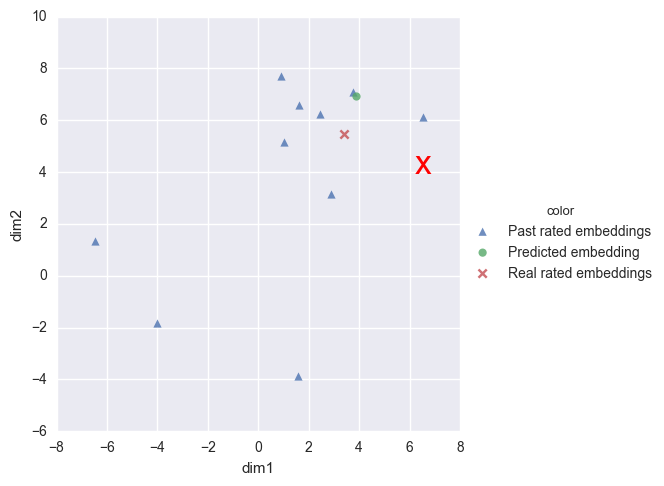

In [49]:
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False, markers=["^", "o", "x"], scatter_kws={"s": 35})
ax.fig.axes[0].annotate('x', (x_pos, y_pos), fontsize=24, color='red')
plt.show()

load model: checkpoints/rep2-lstm2-256-1-128-adam-10000000000-20170612-112727/copies_model/last_model.ckpt-5248000
DEBUG
<class 'str'>
random
Condition 1:
False
Condition 2:
False
END DEBUG


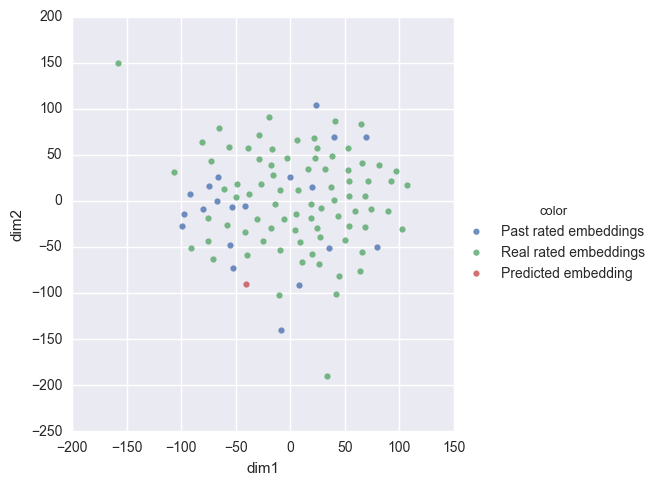

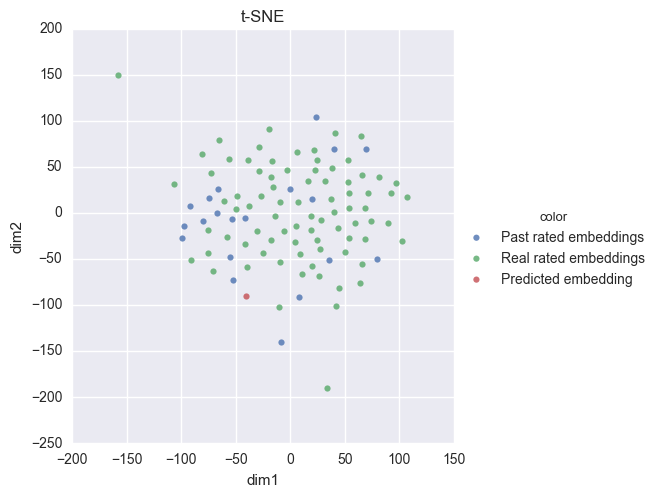

In [32]:
# With only the embeddings of the sample
batch_size = 20
for i in range(0, len(X_test), batch_size):
    x_test = [x for x in X_test[i:i + batch_size]]
    y_test = [y.toarray() for y in Y_test[i:i + batch_size]]
    x_test2 = [x.toarray() for x in X_test2[i:i+batch_size]]
    logits, y_pred = model.predict(x_test, checkpoint_path)
    for j in range(len(y_pred)):
        embeddings_show = []
        embeddings_type = []
        # Obtain embeddings of the previous watched movies
        _, l_already_watched = np.where(x_test2[j] == 1) # Checck the order
        for one_hot_pos in l_already_watched[-20:]:
            movie_id = dict_movies[one_hot_pos]
            embeddings_show.append(word2vec[str(movie_id)])
            embeddings_type.append('Past rated embeddings')
        # Obtain real rated future movies
        _, y_true_idx = np.where(y_test[j] ==1)
        for one_hot_pos in y_true_idx:
            movie_id = dict_movies[one_hot_pos]
            embeddings_show.append(word2vec[str(movie_id)])
            embeddings_type.append('Real rated embeddings')
        # Obtain predicted embedding
        embeddings_show.append(y_pred[j])
        embeddings_type.append('Predicted embedding')
        # Train TSNE
        data_tsne_new = np.array(embeddings_show)
        model_tsn_new = TSNE(n_components=2, random_state=17)
        Y_tsn_new = model_tsn_all.fit_transform(data_tsne_new)
        # Create dataframe and plot
        df_show = pd.DataFrame(Y_tsn_new, columns=['x', 'y'])
        #df_show.columns = ['x', 'y']
        df_show['type_embedding'] = embeddings_type
        df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['type_embedding']))
        sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
        plt.title('t-SNE')
        plt.show()
        break
    break

In [26]:
df_show

,0,1
0,-67.501607,-0.359301
1,-41.189256,-5.124648
2,19.830117,15.319801
3,-55.622702,-48.153550
4,79.591666,-50.311275
5,-91.989473,7.116276
6,0.214378,25.513908
7,-8.564207,-139.542095
8,-66.255308,25.963872
9,8.364102,-91.201562


In [22]:
dict_movieId_pos

{'7035': 0,
 '3391': 2,
 '85259': 3,
 '1284': 4,
 '5672': 5,
 '1541': 6,
 '3946': 7,
 '32234': 8,
 '108979': 9147,
 '4450': 10,
 '8507': 11,
 '1544': 12,
 '89047': 13,
 '91128': 14,
 '51991': 15,
 '33603': 16,
 '73049': 17,
 '51037': 18,
 '86320': 19,
 '538': 20,
 '3676': 21,
 '7259': 9608,
 '80864': 22,
 '3770': 23,
 '431': 8460,
 '3648': 7562,
 '5099': 26,
 '105835': 28,
 '73713': 29,
 '4920': 30,
 '67839': 9011,
 '2178': 31,
 '91323': 9689,
 '1056': 33,
 '6966': 215,
 '47940': 36,
 '55901': 37,
 '62394': 38,
 '3788': 39,
 '248': 40,
 '58492': 41,
 '94833': 42,
 '7984': 278,
 '82765': 44,
 '47976': 46,
 '7354': 47,
 '83829': 5735,
 '34332': 49,
 '54796': 7966,
 '186': 50,
 '5447': 51,
 '78856': 52,
 '80844': 53,
 '58324': 361,
 '55272': 55,
 '63082': 8396,
 '106839': 58,
 '5250': 10003,
 '2939': 6516,
 '74': 61,
 '5309': 62,
 '107117': 63,
 '7154': 6768,
 '3635': 65,
 '45361': 9916,
 '71318': 1693,
 '66317': 68,
 '42': 70,
 '3072': 72,
 '1965': 73,
 '5812': 74,
 '6322': 75,
 '5788': 

In [20]:
df_movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
5,6,Heat (1995),Action|Crime|Thriller,1995
6,7,Sabrina (1995),Comedy|Romance,1995
7,8,Tom and Huck (1995),Adventure|Children,1995
8,9,Sudden Death (1995),Action,1995
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995


In [16]:
Y_tsn_all

array([[ 0.89228908,  6.76155617],
       [-1.62143782,  6.74390292],
       [-2.23981832, -1.35104641],
       ..., 
       [ 2.13679915, -1.47396943],
       [-7.33176459, -0.05618459],
       [ 7.9637085 ,  0.79101345]])

In [48]:
data_tsne[-2]

array([ 0.88513958, -0.24942379, -0.1758    ,  0.4632802 ,  0.37018386,
        0.50273067, -0.00896643,  0.54635715,  0.32675833, -0.73985803,
       -0.30750099, -0.81480831, -0.35946599, -0.00904059, -0.68203813,
        0.45006058, -0.84291458, -0.25709096, -0.54649949,  0.21963409,
        0.17837271, -0.06698009, -0.84781063, -0.5513081 , -0.07015035,
       -0.59100288,  0.43197465, -0.2771771 , -0.08828897,  0.21844693,
        0.22681107,  0.30378315,  0.05434584,  0.4842698 , -0.67098242,
       -0.11663159, -0.23635897, -0.33369336, -0.37061679, -0.1232537 ,
        0.43382791, -0.12374453, -0.24531402, -0.45084652, -0.13447665,
        0.35649112, -0.17416625, -0.3883163 , -0.97813743, -0.2381179 ,
       -0.25392711,  0.75838935, -0.03717552,  0.46239501,  0.29473603,
        0.28890648, -0.28142989, -0.36025667,  0.00803071, -0.74530458,
       -0.1606009 ,  0.20548353, -0.02943771, -0.22774813], dtype=float32)